# Preprocessing Parcel Data

## Brainstation Capstone Project

### Spencer Cox
### July 15, 2022

### Work Plan

The objective of data preprocessing is to create a geopandas database containing information on corporate ownership and investement into residential real estate in the Twin Cities metropolitan region. 

The broader metropolitan area of the Twin Cities contains seven main counties.
   1) Hennepin County, which contains the city of Minneapolis
   2) Ramsey County, which contains the city of St Paul
   3) Washington County
   4) Carver County
   5) Scott County
   6) Dakota County
   7) Anoka County
   
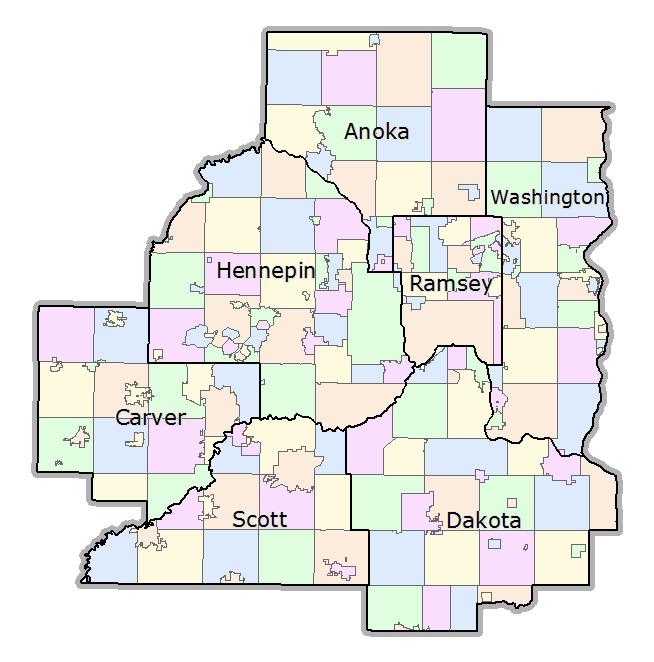


Each county is linked by the Met Council which maintains a central data repository, however each maintains unique data collection systems on parcel ownership.

Objective One: Find and load parcel data for each county as a geopandas dataframe.

Ideal data set will contain one row for each parcel, with each parcel stored geographically as a point feature (lat/lon). 

Property ID, Title Type, Owner Name, Sale Date, Year Built, Sale Price, Total Estimated Market Value, Total Taxable Market Value, Property Type, Homestead Code, Owner Percent, Lat, Lon


Our main goal is to identify corporate landlords, and we will borrow methodology techniques from Redfin analysists in this article [here](https://www.redfin.com/news/investor-home-purchases-q1-2022/).


   

Key to our analysis is to understand which residential properties are owned by corporate real estate investors in contradistinction to smaller local landlords or owner-occupied units. Our datasets, however, contain information on *every* parcel - commercial, industrial, institutional, residential etc.

Objective Two: Extract only residential parcels from each county parcel dataset.



In [2]:
# Import key packages for data pre-processing

import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# Set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'



## Load Parcel Data as Points into Geodatabases

The parcel datasets for the 7 county metro area is collected by the Metro Council, and can be found [here](https://gisdata.mn.gov/dataset/us-mn-state-metrogis-plan-regonal-parcels-2021). The Met Council standardizes the open data county datasets, however, each is still unique in terms of completeness. The completeness matrix of the parcel datasets can be found [here](https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metrogis/plan_regonal_parcels_2021/metadata/Metro_Regional_Parcel_Attributes_2021.pdf) and the meta data [here](https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metrogis/plan_regonal_parcels_2021/metadata/metadata.html).

In terms of spatial datatypes, parcel formats can be found in either a polygon format that contains the actual shape of the parcel, or as a point file based on the geographic centroid. Individual parcels can have more than one entry (ie: Condominiums will have multiple tax payers on the same parcel for each individual unit). For our analysis, we will use point rather than polygon data as we will be assessing corporate onwership as a function of residential density per census tract.

We will load each parcel dataset and extract the key attributes for our analysis. Once each individual county is pre-processed, we will join each of the parcel datasets together to have a 'mother' assessment of corporate owned parcels.

## Attribute Inclusion

The MetCouncil parcel dataset contains 94 unique attributes. The attribute completeness of the datasets are very inconsistent (see the metadata containing the Metro Regional Parcel Dataset Attributes). Based on this data, there is relative completeness of these relevant attributes we will extract for our analysis:
 
 1) County PIN `COUNTY_PIN`
 
 2) Tax Name `TAX_NAME`
 
 3) Homestead Extension `HOMESTEAD`
 
 4) Estimated Value Total `EMV_TOTAL`
 
 5) Use Classification 1 `USECLASS1`
     -- Use classification varies for each county, making cross comparison sloppy. I am going to standardize this data into main categories: 
     
     1) Single_family (Parcels where the single parcel matches a single owner, which includes detached single family homes, condos and manufactured homes) 
     
     2) Multifamily_Small (single parcels may contain more than one but no more than 3 units - duplex and triplex), 
     
     3) Multifamily_large (single parcles that contain more than 4 individual units - quadplexes and apartment buildings
     )
 
 6) geometry
 
I'm going to also investigate if the data is more complete for date sold for residential houses compared to all other parcels.

Unfortunately number of units data availability differs, with Hennepin County entirely lacking number of units.


## Clean County Shapefiles
As each county's attribute completion differs, we will pre-process each dataset separately to get the most complete and cleaned dataset for each county independently prior to joining the counties together into a single dataset.

I will begin by extracting all residential units via the Use Classification attribute.

Once all residential units are extracted, I will then only include units that include a tax name, excluding non-nulls.

I will also only use parcels where the estimated value total is present.

I should be left with a cleaned parcel dataset that includes the parcel, its geographic location, the tax payer on the parcel, its estimated value, and its use.

I will preprocess each county data similarly to arrive at 7 cleaned parcel datasets to then be joined together.

## Corporate Ownership

With the joined and clean dataset, I will then create additional features to assess corporate ownership.

To recap, Redfin looked at county sale records and parcel data for homes purchased from January 2000 through March 2022. Investors are defined as any buyer whose name includes at least one of the following keywords: LLC, Inc, Trust, Corp, Homes. Included in this analysis was the sale price of each home, which they then compared to regional averages.

I will define 'corporate' ownership based both on the containing of keywords *and* on a threshold of properties owned, creating a distinction from 'Mom and Pop' investors from much larger corporate owners. If a single taxable owner owns 3 or more properties across the entire metropolitan area and fits the criteria, we will classify that owner as 'corporate.' This tag is open for interpretation. The logic is based on differences in landlord behavior from 'profit-maximizers,' or entities that seek to maximize the investment value of the home, from 'local' owners who may consider more than just maximum value alone in rental pricing.

### Anoka County

In [3]:
#Anoka County (1)
anoka_gdf = gpd.read_file('shp_plan_regonal_parcels_2021/Parcels2021AnokaPoints.shp')


In [4]:
print(f'The Anoka County geodataframe has {anoka_gdf.shape[0]} entries and {anoka_gdf.shape[1]} attributes')

The Anoka County geodataframe has 136871 entries and 94 attributes


In [5]:
# Preview
anoka_gdf.head()

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry
0,PINS PENDING,27003-PINS PENDING,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55303,None,Ramsey,02396311,ANOKA,27003,Anoka,MN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No,0.370000,0.0,0,0,0,2022,2021,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,18,None,01-0011,Lower Rum River WMO,28,32,25,0,0,003-PINS PENDING,15206,POINT (463876.314 5009627.465)
1,PINS PENDING,27003-PINS PENDING,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55005,None,Oak Grove,02395282,BETHEL,27003,Anoka,MN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No,18.695710,0.0,0,0,0,2022,2021,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,18,None,01-0015,Upper Rum River WMO,2,33,24,0,0,003-PINS PENDING,15273,POINT (476605.207 5025473.909)
2,PINS PENDING,27003-PINS PENDING,None,20673,None,None,None,None,None,Rum River,Boulevard,Northwest,None,None,None,None,None,55303,None,Oak Grove,02395282,ANOKA,27003,Anoka,MN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No,0.905140,0.0,0,0,0,2022,2021,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,18,None,01-0015,Upper Rum River WMO,18,33,24,0,0,003-PINS PENDING,18548,POINT (470842.587 5021437.522)
3,PINS PENDING,27003-PINS PENDING,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55303,None,Oak Grove,02395282,ANOKA,27003,Anoka,MN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No,7.258338,0.0,0,0,0,2022,2021,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,18,None,01-0015,Upper Rum River WMO,6,33,24,0,0,003-PINS PENDING,19493,POINT (470540.537 5025700.072)
4,PINS PENDING,27003-PINS PENDING,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55014,None,Lino Lakes,02395725,CIRCLE PINES,27003,Anoka,MN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No,4.407592,0.0,0,0,0,2022,2021,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,18,None,01-0012,Rice Creek WSD,31,31,22,0,0,003-PINS PENDING,19826,POINT (489808.305 4997099.551)


In [6]:
# General Info
anoka_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 136871 entries, 0 to 136870
Data columns (total 94 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   COUNTY_PIN  136871 non-null  object  
 1   STATE_PIN   136871 non-null  object  
 2   ANUMBERPRE  0 non-null       object  
 3   ANUMBER     136871 non-null  int64   
 4   ANUMBERSUF  251 non-null     object  
 5   ST_PRE_MOD  0 non-null       object  
 6   ST_PRE_DIR  425 non-null     object  
 7   ST_PRE_TYP  0 non-null       object  
 8   ST_PRE_SEP  0 non-null       object  
 9   ST_NAME     123544 non-null  object  
 10  ST_POS_TYP  123125 non-null  object  
 11  ST_POS_DIR  106743 non-null  object  
 12  ST_POS_MOD  0 non-null       object  
 13  SUB_TYPE1   2716 non-null    object  
 14  SUB_ID1     5175 non-null    object  
 15  SUB_TYPE2   0 non-null       object  
 16  SUB_ID2     0 non-null       object  
 17  ZIP         136871 non-null  object  
 18  ZIP4        0 no

### Extract and Reclassify Residential Parcels

In [7]:
# Identify Residential Uses
anoka_gdf['USECLASS1'].value_counts(dropna = False)

RESIDENTIAL SINGLE FAMILY-IMPROVED          95121
TOWNHOMES-IMPROVED                          11085
CONDOMINIUMS -IMPROVED                       6259
RESIDENTIAL SINGLE FAMILY-VACANT             4703
COMMERCIAL / GOLF COURSE-IMPROVED            2168
None                                         2105
EXEMPT- MUNI OTHER                           1955
QUADS-IMPROVED                               1754
TOWNHOMES-VACANT                             1353
INDUSTRIAL-IMPROVED                          1278
DUPLEXES, DOUBLE BUNGALOWS -IMPROVED         1018
APARTMENTS / COOP-IMPROVED                    760
EXEMPT- MUNI PUBLIC SERVICE                   702
COMMERCIAL / GOLF COURSE-VACANT               663
EXEMPT- COUNTY OTHER                          594
AG CLASS 2A BARE LAND (LESS THAN 34.5 AC      495
EXEMPT- DNR PAY IN LIEU OF TAX (ACQ)          351
EXEMPT CHURCH PROPERTY                        325
AG CLASS 2A LAND WITH BLDGS (LESS THAN 3      313
INDUSTRIAL-VACANT                             313


#### Analysis.
According to the documentation, some parcels such as right of ways, public areas within condominiums, or spaces without any direct tax payer do not have a use, and are stored as null. Accordingly we can safely drop the nulls. Next we want to *keep* only residential.

In [8]:
# Keep only residential

residential = ['RESIDENTIAL SINGLE FAMILY-IMPROVED','TOWNHOMES-IMPROVED', 
               'CONDOMINIUMS -IMPROVED', 'RESIDENTIAL SINGLE FAMILY-VACANT','QUADS-IMPROVED',
              'TOWNHOMES-VACANT', 'DUPLEXES, DOUBLE BUNGALOWS -IMPROVED', 'APARTMENTS / COOP-IMPROVED', 
               'APARTMENTS / COOP-VACANT', 'MANUFACTURED HOME PARK-IMPROVED', 'QUADS-VACANT', 
               'CONDOMINIUMS-VACANT', 'DUPLEXES, DOUBLE BUNGALOWS -VACANT', 'MANUFACTURED HOME PARK-VACANT', 
               'MANUFACTURED HOME']

anoka_res = anoka_gdf[anoka_gdf['USECLASS1'].isin(residential)]


In [9]:
# Confirm intended result (making sure that each value in residential is also represented below)

anoka_res['USECLASS1'].value_counts(dropna = False)


RESIDENTIAL SINGLE FAMILY-IMPROVED      95121
TOWNHOMES-IMPROVED                      11085
CONDOMINIUMS -IMPROVED                   6259
RESIDENTIAL SINGLE FAMILY-VACANT         4703
QUADS-IMPROVED                           1754
TOWNHOMES-VACANT                         1353
DUPLEXES, DOUBLE BUNGALOWS -IMPROVED     1018
APARTMENTS / COOP-IMPROVED                760
APARTMENTS / COOP-VACANT                  101
MANUFACTURED HOME PARK-IMPROVED            92
QUADS-VACANT                               18
CONDOMINIUMS-VACANT                        15
DUPLEXES, DOUBLE BUNGALOWS -VACANT          8
MANUFACTURED HOME PARK-VACANT               6
MANUFACTURED HOME                           1
Name: USECLASS1, dtype: int64

Now that we have a geodataframe with just residential parcels, we will separate residential parcels into different standardized types outlined in the introduction.

Single_Family: `RESIDENTIAL SINGLE FAMILY-IMPROVED`, `TOWNHOMES-IMPROVED`, `RESIDENTIAL SINGLE FAMILY-VACANT`, `TOWNHOMES-VACANT` , `MANUFACTURED HOME`, `CONDOMINIUMS -IMPROVED`,`CONDOMINIUMS-VACANT` 

Multifamily_Small: `DUPLEXES, DOUBLE BUNGALOWS -IMPROVED`, `DUPLEXES, DOUBLE BUNGALOWS -VACANT`, 

Multifamily_Large: `MANUFACTURED HOME PARK-VACANT`, `MANUFACTURED HOME PARK-IMPROVED`, `APARTMENTS / COOP-IMPROVED`, `APARTMENTS / COOP-VACANT`, `QUADS-IMPROVED`, `QUADS-VACANT`

In [10]:
#Reclassify USECLASS1

Single_Family = ['RESIDENTIAL SINGLE FAMILY-IMPROVED', 'TOWNHOMES-IMPROVED', 
              'RESIDENTIAL SINGLE FAMILY-VACANT', 'TOWNHOMES-VACANT', 'MANUFACTURED HOME', 
              'CONDOMINIUMS -IMPROVED','CONDOMINIUMS-VACANT']

Multifamily_Small = ['DUPLEXES, DOUBLE BUNGALOWS -IMPROVED', 'DUPLEXES, DOUBLE BUNGALOWS -VACANT']

Multifamily_Large = ['MANUFACTURED HOME PARK-VACANT', 'MANUFACTURED HOME PARK-IMPROVED', 
                     'APARTMENTS / COOP-IMPROVED', 'APARTMENTS / COOP-VACANT', 
                     'QUADS-IMPROVED', 'QUADS-VACANT']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

anoka_res.loc[anoka_res['USECLASS1'].isin(Single_Family), 'Use_Class'] = 'Single_Family'
anoka_res.loc[anoka_res['USECLASS1'].isin(Multifamily_Small), 'Use_Class'] = 'Multifamily_Small'
anoka_res.loc[anoka_res['USECLASS1'].isin(Multifamily_Large), 'Use_Class'] = 'Multifamily_Large'



In [11]:
# Sanity Check (sum should be the same size as anoka_res)
anoka_res['Use_Class'].value_counts(dropna = False)

Single_Family        118537
Multifamily_Large      2731
Multifamily_Small      1026
Name: Use_Class, dtype: int64

### Transform Sale Date to Year (integer) and Interpolate Sale Date

The sale date is a challenging column. It usually contains substantial null values, often for differing reasons. As mentioned in the introduction, the null values will be systematically negoitated in Part II of the pre-processing. For now, will simply convert Sale Date to a year stored as an integer.

In [12]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
anoka_res['Last_Sale_Date'] = anoka_res['SALE_DATE'].str[:4]

# Fill nas as 0 for the time being
anoka_res['Last_Sale_Date'] = anoka_res['Last_Sale_Date'].fillna(0).astype(int)

#Convert to int
anoka_res['Last_Sale_Date'] = anoka_res['Last_Sale_Date'].astype(int)

In [13]:
Sale0 = anoka_res.loc[anoka_res['Last_Sale_Date'] == 0]
print(f'There are {Sale0.shape[0]} parcels with Sale Date = 0, or {Sale0.shape[0]/anoka_res.shape[0]*100}% of total residential properties.')

There are 35829 parcels with Sale Date = 0, or 29.297430781559193% of total residential properties.


In [14]:
Sale0.head()

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
527,363425410006,27003-363425410006,None,4856,None,None,None,None,None,232Nd,Avenue,Northwest,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,10,3,SEELYE BROOK ADD,FOSSE DAVID B & ELVIRA,None,4856 232ND AVE NW,ST FRANCIS,55070,None,FOSSE DAVID B & ELVIRA,4856 232ND AVE NW,ST FRANCIS,55070,None,None,Yes,6.247713,0.0,104200,433700,537900,2022,2021,5474,5313,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",One Story,2618,Yes,0,Yes,Forced Air Furnace,None,1996,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,36,34,25,0,0,003-363425410006,533,POINT (469374.511 5026384.153),Single_Family,0
528,363425410005,27003-363425410005,None,23276,None,None,None,None,None,Salish,Street,Northwest,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,9,3,SEELYE BROOK ADD,GARAGHTY PATRICK J & DEBRA K,None,23276 SALISH ST NW,ST FRANCIS,55070,None,GARAGHTY PATRICK J & DEBRA K,23276 SALISH ST NW,ST FRANCIS,55070,None,None,Yes,5.865698,0.0,99500,254500,354000,2022,2021,3486,3145,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",One Story,1436,Yes,0,Yes,Forced Air Furnace,None,1998,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,36,34,25,0,0,003-363425410005,498,POINT (469323.226 5026492.734),Single_Family,0
537,363425320003,27003-363425320003,None,23146,None,None,None,None,None,Bridgestone,Road,Northwest,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,None,None,None,LEWIS DOUGLAS S & KRISTIN B,None,23146 BRIDGESTONE RD NW,ST FRANCIS,55070,None,LEWIS DOUGLAS S & KRISTIN B,23146 BRIDGESTONE RD NW,ST FRANCIS,55070,None,None,Yes,9.706982,10.0,132200,199700,331900,2022,2021,3245,3030,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",Bi-level,1068,Yes,0,Yes,Forced Air Furnace,None,1977,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,36,34,25,0,0,003-363425320003,117884,POINT (468179.459 5026343.898),Single_Family,0
539,363425310004,27003-363425310004,None,23157,None,None,None,None,None,Bridgestone,Road,Northwest,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,None,None,None,SCOTT ZACHARY J & CHARISSA J,None,23157 BRIDGESTONE RD NW,ST FRANCIS,55011,None,SCOTT ZACHARY J & CHARISSA J,23157 BRIDGESTONE RD NW,ST FRANCIS,55011,None,None,Yes,9.693113,9.9,129600,333000,462600,2022,2021,4626,4794,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",One Story,1578,Yes,0,Yes,Forced Air Furnace,None,1996,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,36,34,25,0,0,003-363425310004,117879,POINT (468592.463 5026334.920),Single_Family,0
542,363425240001,27003-363425240001,None,23335,None,None,None,None,None,Bridge

After checking severa on Zillow, all have not been sold, remaining with the original owner. I'll extrapolate that properties that haven't been sold recently have actually not been sold, meaning we'll put 'last_sale_date' equal to the year built.

In [15]:
anoka_res.loc[anoka_res['Last_Sale_Date'] ==0, 'Last_Sale_Date'] = anoka_res['YEAR_BUILT']

In [16]:
sale0_2 = anoka_res.loc[anoka_res['Last_Sale_Date'] == 0]

In [17]:
# Check the uses of properties
sale0_2.USECLASS1.value_counts()

RESIDENTIAL SINGLE FAMILY-VACANT        2124
TOWNHOMES-VACANT                         725
CONDOMINIUMS -IMPROVED                   244
RESIDENTIAL SINGLE FAMILY-IMPROVED       214
TOWNHOMES-IMPROVED                        69
APARTMENTS / COOP-VACANT                  61
MANUFACTURED HOME PARK-IMPROVED           39
QUADS-VACANT                              17
QUADS-IMPROVED                             8
CONDOMINIUMS-VACANT                        7
APARTMENTS / COOP-IMPROVED                 6
MANUFACTURED HOME PARK-VACANT              3
DUPLEXES, DOUBLE BUNGALOWS -VACANT         3
DUPLEXES, DOUBLE BUNGALOWS -IMPROVED       1
MANUFACTURED HOME                          1
Name: USECLASS1, dtype: int64

It appears the remaining columns fall into two main buckets. The first are vacant properties, and the second are 'improved' properties, which often contain strange parcels (such as patios, or parking spots, that can be removed from the analysis). Manufactured Hom(1) is the only lone wolf in neither bucket. 

Vacant properties can be registered in the state of Minnesota as vacant, however it is strange that it would then remove the year-built information or last sale date. For these, I will leave year built as 0, but still include the properties in the analysis.

Improved is still a bit of a mystery, as the property values seem to vary widely. I'll leave sale_date as 0 but keep the properties in the analysis.

In [18]:
#Extract Vacant
sale0_vacant = sale0_2.loc[sale0_2['USECLASS1'].str.contains(r'\bVACANT\b')]
sale0_vacant['USECLASS1'].value_counts()

RESIDENTIAL SINGLE FAMILY-VACANT      2124
TOWNHOMES-VACANT                       725
APARTMENTS / COOP-VACANT                61
QUADS-VACANT                            17
CONDOMINIUMS-VACANT                      7
MANUFACTURED HOME PARK-VACANT            3
DUPLEXES, DOUBLE BUNGALOWS -VACANT       3
Name: USECLASS1, dtype: int64

In [19]:
#Extract Improved
sale0_improved = sale0_2.loc[sale0_2['USECLASS1'].str.contains(r'\bIMPROVED\b')]
sale0_improved['USECLASS1'].value_counts()

CONDOMINIUMS -IMPROVED                  244
RESIDENTIAL SINGLE FAMILY-IMPROVED      214
TOWNHOMES-IMPROVED                       69
MANUFACTURED HOME PARK-IMPROVED          39
QUADS-IMPROVED                            8
APARTMENTS / COOP-IMPROVED                6
DUPLEXES, DOUBLE BUNGALOWS -IMPROVED      1
Name: USECLASS1, dtype: int64

In [20]:
sale0_improved.head(10)

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
1067,363323330022,27003-363323330022,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,24,70,COON LAKE BEACH 3RD MAP,TRAINOR PETER D,None,713 BIRCH RD NE,WYOMING,55092,None,TRAINOR PETER D,713 BIRCH RD NE,WYOMING,55092,None,None,Yes,0.08000,0.0,5300,0,5300,2022,2021,53,35,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0831,Sunrise River WMO,36,33,23,0,0,003-363323330022,42789,POINT (487516.608 5016095.840),Single_Family,0
1133,363323240311,27003-363323240311,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,1,11,C L B-1,FAGIN JAMES K & LISA M,None,422 ELM RD,WYOMING,55092,None,FAGIN JAMES K & LISA M,422 ELM RD,WYOMING,55092,None,None,Yes,0.36000,0.0,32100,3900,36000,2022,2021,360,388,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Yes,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0831,Sunrise River WMO,36,33,23,0,0,003-363323240311,41884,POINT (487785.775 5016956.051),Single_Family,0
1141,363323240300,27003-363323240300,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,1616,28,COON LAKE BEACH,LEONARD DARLENE J,None,301 LINCOLN DR NE,WYOMING,55092,None,LEONARD DARLENE J,301 LINCOLN DR NE,WYOMING,55092,None,None,Yes,0.04000,0.0,5300,8300,13600,2022,2021,136,165,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Yes,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0831,Sunrise River WMO,36,33,23,0,0,003-363323240300,47487,POINT (487989.807 5016964.190),Single_Family,0
1162,363323240256,27003-363323240256,None,439,None,None,None,None,None,Forest,Road,Northeast,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,1471,25,COON LAKE BEACH,KINCADE DELBERT J & DONNA K,None,439 FOREST RD NE,WYOMING,55092,None,KINCADE DELBERT J & DONNA K,439 FOREST RD NE,WYOMING,55092,None,None,Yes,0.09000,0.0,19200,5800,25000,2022,2021,250,276,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Yes,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0831,Sunrise River WMO,36,33,23,0,0,003-363323240256,41759,POINT (487802.264 5016901.132),Single_Family,0
1266,363323230176,27003-363323230176,None,347,None,None,None,None,None,Birch,Road,Northeast,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,749,18,None,LOCH TIMOTHY,None,23231 166TH ST,BIG LAKE,55309,None,"LOCH, TIMOTHY J",23231 166TH ST,BIG LAKE,55309,None,None,No,0.91782,0.0,90800,200,91000,2022,2021,910,0,0,RESIDENTIAL SINGLE FAMILY-IMPR

In [21]:
sale_manufacture = sale0_2.loc[sale0_2['USECLASS1'].str.contains(r'\bMANUFACTURED\b')]
sale_manufacture.head(50)

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
13980,343123410002,27003-343123410002,None,8770,None,None,None,None,None,Naples,Street,Northeast,None,None,None,None,None,55449,None,Blaine,02394183,MINNEAPOLIS,27003,Anoka,MN,None,None,None,BP AMERICA INC,None,PO BOX 941709,HOUSTON,77094,None,BP AMERICA INC,PO BOX 941709,HOUSTON,77094,None,None,No,0.700000,0.70,151600,0,151600,2022,2021,1895,2233,0,MANUFACTURED HOME PARK-VACANT,None,None,None,None,None,None,None,None,None,MOBILE HOME PARKS,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0012,Rice Creek WSD,34,31,23,0,0,003-343123410002,77629,POINT (485476.771 4997331.526),Multifamily_Large,0
18797,323323340005,27003-323323340005,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55011,None,East Bethel,02394596,CEDAR,27003,Anoka,MN,None,None,None,VILLAGE GREEN NORTH,None,620 CIVIC HEIGHTS DR STE 101,CIRCLE PINES,55014,None,VILLAGE GREEN NORTH,620 CIVIC HEIGHTS DR STE 101,CIRCLE PINES,55014,None,None,No,8.370000,8.90,1318900,0,1318900,2022,2021,16486,20345,0,MANUFACTURED HOME PARK-IMPROVED,None,None,None,None,None,None,None,None,None,MOBILE HOME PARKS,None,0,Unknown,0,Unknown,None,None,0,54,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,32,33,23,0,0,003-323323340005,41137,POINT (481485.441 5016183.898),Multifamily_Large,0
18798,323323340003,27003-323323340003,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55011,None,East Bethel,02394596,CEDAR,27003,Anoka,MN,None,None,None,VILLAGE GREEN NORTH,None,620 CIVIC HEIGHTS DR STE 101,CIRCLE PINES,55014,None,VILLAGE GREEN NORTH,620 CIVIC HEIGHTS DR STE 101,CIRCLE PINES,55014,None,None,No,6.540000,6.56,943600,0,943600,2022,2021,11795,17004,0,MANUFACTURED HOME PARK-IMPROVED,None,None,None,None,None,None,None,None,None,MOBILE HOME PARKS,None,0,Unknown,0,Unknown,None,None,0,38,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,32,33,23,0,0,003-323323340003,46571,POINT (481314.616 5016337.311),Multifamily_Large,0
18818,323323320001,27003-323323320001,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55011,None,East Bethel,02394596,CEDAR,27003,Anoka,MN,None,None,None,VILLAGE GREEN,None,620 CIVIC HEIGHTS DR STE 101,CIRCLE PINES,55014,None,VILLAGE GREEN NORTH,620 CIVIC HEIGHTS DR STE 101,CIRCLE PINES,55014,None,None,No,24.830000,24.87,133500,3300,136800,2022,2021,1710,2041,0,MANUFACTURED HOME PARK-IMPROVED,None,None,None,None,None,None,None,None,None,MOBILE HOME PARKS,None,0,Yes,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,32,33,23,0,0,003-323323320001,41502,POINT (480948.778 5016644.296),Multifamily_Large,0
21969,313424240003,27003-313424240003,None,4311,None,None,None,None,None,235Th,Avenue,Northwest,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,None,None,None,A L S PROPERTIES WOODHAVEN LLC,None,5501 LAKELAND AVE N,CRYSTAL,55429,None,A L S PROPERTIES WOODHAVEN LLC,5501 LAKELAND AVE N,

### Assess Completeness

The main items to asssess for completeness include Homestead status (y/n, complete) and EMV_TOTAL, ensuring that the estimated taxable value is listed. In certain circumstances, no value is given for EMV_TOTAL, which will require unique considerations per county.

In [22]:
# Assess Homestead
anoka_res['HOMESTEAD'].value_counts(dropna = False)

Yes    100858
No      21436
Name: HOMESTEAD, dtype: int64

In [23]:
# Assess EMV_TOTAL
anoka_res['EMV_TOTAL'].isna().sum()

0

In [24]:
# Assess for values listed as 0 - 920 values are listed
anoka_emv0 = anoka_res.loc[anoka_res['EMV_TOTAL'] == 0]
anoka_emv0.shape

(920, 96)

In [25]:
# What features are shared in common?
anoka_emv0['USECLASS1'].value_counts()

TOWNHOMES-VACANT                      584
RESIDENTIAL SINGLE FAMILY-VACANT      254
RESIDENTIAL SINGLE FAMILY-IMPROVED     47
QUADS-VACANT                           17
CONDOMINIUMS-VACANT                    12
APARTMENTS / COOP-VACANT                3
CONDOMINIUMS -IMPROVED                  1
TOWNHOMES-IMPROVED                      1
APARTMENTS / COOP-IMPROVED              1
Name: USECLASS1, dtype: int64

In [26]:
anoka_emv0.loc[anoka_emv0['SALE_VALUE'] > 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
3713,363123320051,27003-363123320051,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55014,None,Blaine,02394183,CIRCLE PINES,27003,Anoka,MN,None,A,WESTON WOODS ON RICE CREEK,WESTON WOODS ON RICE CREEK ASSOCIATION,None,8777 FRAZIER STREET,BLAINE,55014,None,WESTON WOODS ON RICE CREEK ASSOCIATION,8777 FRAZIER STREET,BLAINE,55014,None,None,No,1.400000,0.00,0,0,0,2022,2021,0,0,0,TOWNHOMES-VACANT,None,None,None,None,None,None,None,None,None,PATIO-TOWNHOME,None,0,Unknown,0,Unknown,None,None,0,0,2014-09-22,500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0012,Rice Creek WSD,36,31,23,0,0,003-363123320051,128114,POINT (487442.301 4997339.649),Single_Family,2014
12266,343323340005,27003-343323340005,None,2816,None,None,None,None,None,183Rd,Avenue,Northeast,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,None,None,None,"KAISER, KENNETH",None,2816 183RD AVE NE,EAST BETHEL,55092,None,"KAISER, KENNETH",2816 183RD AVE NE,EAST BETHEL,55092,None,None,No,2.797593,3.11,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,2020-06-10,306500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Sunrise River WMO,34,33,23,0,0,003-343323340005,136815,POINT (484466.814 5016373.380),Single_Family,2020
13678,343224130003,27003-343224130003,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55304,None,Andover,02393954,ANDOVER,27003,Anoka,MN,1A,2,PARKSIDE AT ANDOVER STATION,PARKSIDE TOWNHOMES HOMEOWNERS ASSOC INC,None,35 LAKE ST S,BIG LAKE,55309,None,PARKSIDE TOWNHOMES HOMEOWNERS ASSOC INC,35 LAKE ST S,BIG LAKE,55309,None,None,No,0.090000,0.00,0,0,0,2022,2021,0,0,0,TOWNHOMES-VACANT,None,None,None,None,None,None,None,None,None,PATIO-TOWNHOME,None,0,Unknown,0,Unknown,None,None,0,0,2017-06-28,500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0011,Coon Creek WSD,34,32,24,0,0,003-343224130003,108020,POINT (475462.120 5007753.733),Single_Family,2017
13738,343224120031,27003-343224120031,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55304,None,Andover,02393954,ANDOVER,27003,Anoka,MN,1,2,PARKSIDE AT ANDOVER STATION,PARKSIDE TOWNHOMES HOMEOWNERS ASSOC INC,None,35 LAKE ST S,BIG LAKE,55309,None,PARKSIDE TOWNHOMES HOMEOWNERS ASSOC INC,35 LAKE ST S,BIG LAKE,55309,None,None,No,0.060000,0.00,0,0,0,2022,2021,0,0,0,TOWNHOMES-VACANT,None,None,None,None,None,None,None,None,None,PATIO-TOWNHOME,None,0,Unknown,0,Unknown,None,None,0,0,2017-06-28,500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0011,Coon Creek WSD,34,32,24,0,0,003-343224120031,102559,POINT (475464.851 5007788.250),Single_Family,2017
14887,333424430109,27003-333424430109,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,None,C,CIC NO 57 TURTLE RUN 3RD TWNHM,TURTLE RUN THIRD TOWNHOMES ASSOC INC,None,23035 ARROWHEAD ST NW,ST. FRANCIS,55070,None,TURTLE RUN THIRD TOWNHOMES A

#### Analysis
First observation. Numerous parcels here are 'patios' of condos, each with a unique deed but not a value. These will be dropped as they are superflous.

In [27]:
# Drop condominium patio townhome parcels
anoka_res.drop(anoka_res[(anoka_res['EMV_TOTAL'] == 0) & (anoka_res['DWELL_TYPE'] == 'PATIO-TOWNHOME')].index, inplace=True)

In [28]:
# Assess remaining
anoka_res.loc[(anoka_res['EMV_TOTAL'] == 0) & (anoka_res['SALE_VALUE'] > 0)]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
12266,343323340005,27003-343323340005,None,2816,None,None,None,None,None,183Rd,Avenue,Northeast,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,None,None,None,"KAISER, KENNETH",None,2816 183RD AVE NE,EAST BETHEL,55092,None,"KAISER, KENNETH",2816 183RD AVE NE,EAST BETHEL,55092,None,None,No,2.797593,3.11,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,2020-06-10,306500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Sunrise River WMO,34,33,23,0,0,003-343323340005,136815,POINT (484466.814 5016373.380),Single_Family,2020
14887,333424430109,27003-333424430109,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,None,C,CIC NO 57 TURTLE RUN 3RD TWNHM,TURTLE RUN THIRD TOWNHOMES ASSOC INC,None,23035 ARROWHEAD ST NW,ST. FRANCIS,55070,None,TURTLE RUN THIRD TOWNHOMES ASSOC INC,23035 ARROWHEAD ST NW,ST. FRANCIS,55070,None,None,No,0.360979,0.00,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-VACANT,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,2015-07-16,500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,33,34,24,0,0,003-333424430109,3882,POINT (473793.048 5026038.803),Single_Family,2015
25769,303224310007,27003-303224310007,None,4301,None,None,None,None,None,Parkview,Circle,None,None,None,None,None,None,55303,None,Anoka,02393964,ANOKA,27003,Anoka,MN,1,1,RUM RIVER SHORES NORTH,RUM RIVER SHORES HOMEOWNERS ASSOCIATION,None,5707 EXCELSIOR BLVD,ST LOUIS PARK,55416,None,RUM RIVER SHORES HOMEOWNERS ASSOCIATION,5707 EXCELSIOR BLVD,ST LOUIS PARK,55416,None,None,No,0.570000,0.00,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,640,Unknown,0,Unknown,"Baseboard, Hot Water",None,2015,0,2018-06-27,500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0011,Lower Rum River WMO,30,32,24,0,0,003-303224310007,129152,POINT (470064.211 5008667.102),Single_Family,2018
25770,303224310006,27003-303224310006,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55303,None,Anoka,02393964,ANOKA,27003,Anoka,MN,None,D,RUM RIVER SHORES NORTH,RUM RIVER SHORES HOMEOWNERS ASSOCIATION,None,5707 EXCELSIOR BLVD,ST LOUIS PARK,55416,None,RUM RIVER SHORES HOMEOWNERS ASSOCIATION,5707 EXCELSIOR BLVD,ST LOUIS PARK,55416,None,None,No,0.480000,0.00,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-VACANT,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,2018-06-27,500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0011,Lower Rum River WMO,30,32,24,0,0,003-303224310006,129094,POINT (470031.768 5008610.119),Single_Family,2018
32245,283225110255,27003-283225110255,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,55303,None,Ramsey,023963

In [29]:
# Drop values where deeded acres are 0 and EMV is 0
anoka_res.drop(anoka_res[(anoka_res['EMV_TOTAL'] == 0) & (anoka_res['ACRES_DEED'] == 0)].index, inplace=True)

In [30]:
anoka_res.loc[anoka_res['EMV_TOTAL'] == 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
12265,343323340006,27003-343323340006,None,2842,None,None,None,None,None,183Rd,Avenue,Northeast,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,None,None,None,"MATEER, NICOLE L",None,2842 183RD AVE NE,EAST BETHEL,55092,None,"MATEER, NICOLE L",2842 183RD AVE NE,EAST BETHEL,55092,None,None,No,10.922885,12.00,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,2021-06-17,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Sunrise River WMO,34,33,23,0,0,003-343323340006,116566,POINT (484514.448 5016244.394),Single_Family,2021
12266,343323340005,27003-343323340005,None,2816,None,None,None,None,None,183Rd,Avenue,Northeast,None,None,None,None,None,55092,None,East Bethel,02394596,WYOMING,27003,Anoka,MN,None,None,None,"KAISER, KENNETH",None,2816 183RD AVE NE,EAST BETHEL,55092,None,"KAISER, KENNETH",2816 183RD AVE NE,EAST BETHEL,55092,None,None,No,2.797593,3.11,0,0,0,2022,2021,0,0,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",None,0,Unknown,0,Unknown,None,None,0,0,2020-06-10,306500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Sunrise River WMO,34,33,23,0,0,003-343323340005,136815,POINT (484466.814 5016373.380),Single_Family,2020


In [31]:
# Two remaining: one was sold in 2020, the other in 2021 (but is lacking sale price). Will look it up on Zillow (assessed for 378,329).
# impute sale value
anoka_res.at[12265, 'EMV_TOTAL'] = 378329
anoka_res.at[12266, 'EMV_TOTAL'] = 306500


In [32]:
# One missing Tax Parcel
anoka_res.loc[anoka_res.TAX_NAME.isna()]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
100438,113024120052,27003-113024120052,None,7466,None,None,None,None,None,Melody,Drive,Northeast,None,None,None,None,None,55432,None,Fridley,02394826,MINNEAPOLIS,27003,Anoka,MN,29,4,MELODY MANOR 4TH ADD,"PHAM, HUYNH Q",None,841 101ST AVE NE,BLAINE,55434,None,None,841 101ST AVE NE,BLAINE,55434,None,None,No,0.21,0.0,69200,164400,233600,2022,2021,2336,3466,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",Bi-level,888,Yes,0,Yes,Forced Air Furnace,None,1967,0,2015-07-14,142500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0016,Coon Creek WSD,11,30,24,0,0,003-113024120052,41719,POINT (479985.451 4994604.111),Single_Family,2015


In [33]:
#input owner name as tax owner
anoka_res.at[100438, 'TAX_NAME'] = 'PHAM, HUYNH Q'


### Create new column to extract zip code of taxable owner

In [34]:
anoka_res['taxed_zip'] = anoka_res['TAX_ADD_L3']

In [35]:
anoka_res.loc[anoka_res['taxed_zip'].isna()]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date,taxed_zip
15316,333424210116,27003-333424210116,None,2824,None,None,None,None,None,235Th,Avenue,Northwest,None,None,None,None,None,55070,None,Saint Francis,02396487,SAINT FRANCIS,27003,Anoka,MN,4,4,CIC NO 138 STONE HOUSE RIDGE 2,CAMARA AMINATOU,None,TBD UNHCR OFFICE 9,None,None,None,CAMARA AMINATOU,TBD UNHCR OFFICE 9,None,None,None,None,No,0.160684,0.0,12000,183000,195000,2022,2021,1753,1436,0,TOWNHOMES-IMPROVED,None,None,None,None,None,None,None,None,None,PATIO-TOWNHOME,"TOWNHOUSE, BI-LEVEL",987,Yes,0,Yes,Forced Air Furnace,None,2005,0,2021-04-30,234000,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0015,Upper Rum River WMO,33,34,24,0,0,003-333424210116,5387,POINT (473554.287 5026972.773),Single_Family,2021,None
40920,263024430118,27003-263024430118,None,4636,None,None,None,None,None,Washington,Street,Northeast,None,None,None,None,None,55421,None,Columbia Heights,02393607,MINNEAPOLIS,27003,Anoka,MN,18,None,SHEFFIELD ACRES,"DACOSTA, ERNEST C",None,268 BALFOUR AVE,WINNIPEG,None,None,"DACOSTA, MARIA A",268 BALFOUR AVE,WINNIPEG,None,None,None,No,0.150000,0.0,73200,165300,238500,2022,2021,2981,3489,0,"DUPLEXES, DOUBLE BUNGALOWS -IMPROVED",None,None,None,None,None,None,None,None,None,"DB, DU, DE",English duplex,1056,Yes,0,Yes,Forced Air Furnace,None,1960,0,2009-02-28,115500,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0013,Mississippi WMO,26,30,24,0,0,003-263024430118,79433,POINT (479782.225 4988866.348),Multifamily_Small,2009,None
40927,263024430111,27003-263024430111,None,4654,None,None,None,None,None,Washington,Street,Northeast,None,None,None,None,None,55421,None,Columbia Heights,02393607,MINNEAPOLIS,27003,Anoka,MN,15,None,SHEFFIELD ACRES,"DACOSTA, MARIA A",None,268 BALFOUR AVE,WINNIPEG,None,None,"DACOSTA, ERNEST C",268 BALFOUR AVE,WINNIPEG,None,None,None,No,0.180000,0.0,73200,161700,234900,2022,2021,2936,3624,0,"DUPLEXES, DOUBLE BUNGALOWS -IMPROVED",None,None,None,None,None,None,None,None,None,"DB, DU, DE",English duplex,1056,Yes,0,Yes,Forced Air Furnace,None,1960,0,2015-11-05,161000,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0013,Mississippi WMO,26,30,24,0,0,003-263024430111,69549,POINT (479782.321 4988923.147),Multifamily_Small,2015,None
49026,253024240058,27003-253024240058,None,5030,None,None,None,None,None,Johnson,Street,Northeast,None,None,None,None,None,55421,None,Columbia Heights,02393607,MINNEAPOLIS,27003,Anoka,MN,4,7,MATHAIRE,RESTRICTED 25-30-24-24-0058,None,P O BOX 17370,SAINT PAUL,55117,None,RESTRICTED 25-30-24-24-0058,P O BOX 17370,None,None,None,None,Yes,0.220000,0.0,77700,167400,245100,2022,2021,2299,3063,0,RESIDENTIAL SINGLE FAMILY-IMPROVED,None,None,None,None,None,None,None,None,None,"RESIDENTIAL, SINGLE FAMILY",Split Level,1133,Yes,0,Yes,Forced Air Furnace,None,1962,0,None,0,No,No,No,None,None,None,None,2021-12-30,0,0,None,01-0013,Mississippi WMO,25,30,24,0,0,003-253024240058,68830,POINT (481239.672 4989599.269),Single_Family,1962,None
49180,253024230008,27003-253024230008,None,4918,None,None,None,None,None,Tyler,Street,Northeast,None,None,None,None,None,55421,None,Co

In [36]:
# will use owner address
anoka_res.at[49026, 'taxed_zip'] = 55117
#homesteaded
anoka_res.at[85148, 'taxed_zip'] = 55303

In [37]:
# The rest are foreign, will be replaced with 00000
anoka_res['taxed_zip'].fillna(value='00000', inplace=True)

### Create a column for county name

In [38]:
anoka_res['County'] = "Anoka"

### Extract Final Data Set

In [39]:
# Get rid of extraneous columns
anoka_res = anoka_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
anoka_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
525,363425420001,Anoka,VESTA MINNESOTA PROPERTIES LLC,55443,Single_Family,2011,No,1987,343900,POINT (468988.693 5026377.395)
526,363425410007,Anoka,"BRIERLEY, WENDY LOU",55070,Single_Family,2015,Yes,1996,382700,POINT (469548.186 5026281.306)
527,363425410006,Anoka,FOSSE DAVID B & ELVIRA,55070,Single_Family,1996,Yes,1996,537900,POINT (469374.511 5026384.153)
528,363425410005,Anoka,GARAGHTY PATRICK J & DEBRA K,55070,Single_Family,1998,Yes,1998,354000,POINT (469323.226 5026492.734)
529,363425410004,Anoka,LEVAN MICHAEL,55070,Single_Family,2021,No,1995,288900,POINT (469536.277 5026429.696)


In [40]:
anoka_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 121376 entries, 525 to 136870
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   COUNTY_PIN      121376 non-null  object  
 1   County          121376 non-null  object  
 2   TAX_NAME        121376 non-null  object  
 3   taxed_zip       121376 non-null  object  
 4   Use_Class       121376 non-null  object  
 5   Last_Sale_Date  121376 non-null  int64   
 6   HOMESTEAD       121376 non-null  object  
 7   YEAR_BUILT      121376 non-null  int64   
 8   EMV_TOTAL       121376 non-null  int64   
 9   geometry        121376 non-null  geometry
dtypes: geometry(1), int64(3), object(6)
memory usage: 14.2+ MB


## Carver County


In [41]:
# Carver County (2)
carver_gdf = gpd.read_file('shp_plan_regonal_parcels_2021/Parcels2021CarverPoints.shp')

In [42]:
print(f'The Carver County geodataframe has {carver_gdf.shape[0]} entries and {carver_gdf.shape[1]} attributes')

The Carver County geodataframe has 44942 entries and 94 attributes


In [43]:
# Check out the dataframe
carver_gdf.head()

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry
0,856000020,27019-856000020,None,701,None,None,None,None,None,INDUSTRIAL,Boulevard,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,A,None,WORKSHOPS OF WATERTOWN,None,None,None,None,None,None,WORKSHOPS OF WATERTOWN LLC,5145 INDUSTRIAL ST #1,"MAPLE PLAIN, MN 55359-",None,None,None,No,11.77,0.0,0,0,0,0,0,0,0,0,Commercial,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-856000020,1044317,POINT (431721.478 4977850.556)
1,856000010,27019-856000010,None,721,None,None,None,None,None,INDUSTRIAL,Boulevard,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,001,001,WORKSHOPS OF WATERTOWN,None,None,None,None,None,None,WORKSHOPS OF WATERTOWN LLC,5145 INDUSTRIAL ST #1,"MAPLE PLAIN, MN 55359-",None,None,None,No,5.22,0.0,0,0,0,0,0,0,0,0,Commercial,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-856000010,1044316,POINT (431602.344 4977715.009)
2,855350330,27019-855350330,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Watertown,02397211,None,27019,Carver,MN,None,None,WILDFLOWER 6TH ADDITION,None,None,None,None,None,None,WATERTOWN CITY,PO BOX 279,"WATERTOWN, MN 55388-0279",None,None,None,No,0.10,0.0,0,0,0,0,0,0,0,0,Muni Srvc Other,None,None,None,No,Y,Muni Srvc Other,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,OUTLOT B,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-855350330,1038355,POINT (434913.322 4977691.093)
3,855350320,27019-855350320,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Watertown,02397211,None,27019,Carver,MN,None,None,WILDFLOWER 6TH ADDITION,None,None,None,None,None,None,WATERTOWN CITY,PO BOX 279,"WATERTOWN, MN 55388-0279",None,None,None,No,8.39,0.0,0,0,0,0,0,0,0,0,Muni Srvc Other,None,None,None,No,Y,Muni Srvc Other,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,OUTLOT A,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-855350320,1038300,POINT (434853.032 4977796.356)
4,855350310,27019-855350310,None,1855,None,None,None,None,None,IRIS,Drive,None,None,None,None,None,None,55388,8403,Watertown,02397211,Watertown,27019,Carver,MN,003,004,WILDFLOWER 6TH ADDITION,None,None,None,None,None,None,LANCE CIESLEWICZ,1855 IRIS DR,"WATERTOWN, MN 55388-",None,None,None,Yes,0.28,0.0,0,0,0,0,0,2502,3788,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1371,Yes,0,Yes,Forced Air,Yes,2004,0,2021-01-08,334000,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-855350310,1037623,POINT (434645.817 4977618.936)


In [44]:
carver_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 44942 entries, 0 to 44941
Data columns (total 94 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COUNTY_PIN  44641 non-null  object  
 1   STATE_PIN   44942 non-null  object  
 2   ANUMBERPRE  0 non-null      object  
 3   ANUMBER     44942 non-null  int64   
 4   ANUMBERSUF  0 non-null      object  
 5   ST_PRE_MOD  0 non-null      object  
 6   ST_PRE_DIR  0 non-null      object  
 7   ST_PRE_TYP  0 non-null      object  
 8   ST_PRE_SEP  0 non-null      object  
 9   ST_NAME     40251 non-null  object  
 10  ST_POS_TYP  38053 non-null  object  
 11  ST_POS_DIR  5554 non-null   object  
 12  ST_POS_MOD  0 non-null      object  
 13  SUB_TYPE1   0 non-null      object  
 14  SUB_ID1     1067 non-null   object  
 15  SUB_TYPE2   0 non-null      object  
 16  SUB_ID2     0 non-null      object  
 17  ZIP         40236 non-null  object  
 18  ZIP4        40236 non-null  object  
 

Despite having many 'non-null' columns, many of the non-nulls are filled with non-meaningful data. As in the value of properties is, frustratingly, missing. Prior to seeing if values can be imputed, I will first identify residential properties.

### Extract and Reclassify Residential Parcels

In [45]:
# Identify Residential Uses
carver_gdf['USECLASS1'].value_counts(dropna = False)

Res 1 unit                                       34180
Agricultural                                      2559
Res V Land                                        2507
Muni Srvc Other                                   1452
T E Misc Co D 3                                   1169
Commercial                                        1074
Industrial                                         343
None                                               316
Apt 4+ units                                       197
Rural Vacant Land                                  113
Muni Srvc Ent                                       91
Church                                              86
InLieuTx Co D 1                                     66
Schools-Public                                      62
MiscNotReported                                     60
Co Srvc Other                                       55
ForestParkRefuge                                    52
State Property                                      50
Cemetery-P

In [46]:
strange = carver_gdf[carver_gdf['USECLASS1'] == 'T E Misc Co D 1']

In [47]:
strange['ABB_LEGAL'].value_counts()

FORFEITED 6-89                                                         2
W 60' OF TRACT C ANNEXATION ORD #103  (76L/6A) FORFEITED 9/4/08        1
OUTLOT L                                                               1
OUTLOT E                                                               1
OUTLOT B FORFEITED 7/20/98                                             1
TRACT C                                                                1
OUTLOT A FORFEITED 7/17/97                                             1
OUTLOT A FORFEITED 12/93                                               1
S1/2 OF OUTLOT 1 FORFEITED 6-89.                                       1
OUTLOT A                                                               1
OUTLOT A FORFEITED 6-89                                                1
OUTLOT B FORFEITED TO STATE 12/93                                      1
LOTS 564 - 568 FORFEITED 9-29-89                                       1
LOTS 485 - 489 (UNRECORDED STATE DEED) & P/O VACATE

Some of the stranger parcel `USECLASS1` labels such as T E Misc Co D refer to non-taxable common areas, parks, our non-taxed lots. They are excluded from the residential criteria. Res V Land means land parcels that are designated/zoned single family, but currently are not developed. We will exclude these.

After analysis, residential parcels include:
'Res 1 unit'', 'Apt 4+ units', 'Res 2-3 units', 'Low Income Housing HRA Property (with Shelter ', 'L Condo Coop', 'MH Park ', 'MH Park Class I '


In [48]:
# Keep only residential

residential_carver = ['Res 1 unit', 'Apt 4+ units', 'Res 2-3 units', 
                      'Low Income Housing HRA Property (with Shelter', 'L Condo Coop', 
                      'MH Park', 'MH Park Class I']

carver_res = carver_gdf[carver_gdf['USECLASS1'].isin(residential_carver)]

In [49]:
# Check for completeness
carver_res['USECLASS1'].value_counts()

Res 1 unit                                       34180
Apt 4+ units                                       197
Res 2-3 units                                       35
MH Park                                              7
MH Park Class I                                      4
Low Income Housing HRA Property (with Shelter        4
L Condo Coop                                         1
Name: USECLASS1, dtype: int64

In [50]:
#Reclassify USECLASS1

Single_Family_Carver = ['Res 1 unit']

Multifamily_Small_Carver = ['Res 2-3 units']

Multifamily_Large_Carver = ['L Condo Coop', 'Apt 4+ units', 'MH Park', 'MH Park Class I','Low Income Housing HRA Property (with Shelter']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

carver_res.loc[carver_res['USECLASS1'].isin(Single_Family_Carver), 'Use_Class'] = 'Single_Family'
carver_res.loc[carver_res['USECLASS1'].isin(Multifamily_Small_Carver), 'Use_Class'] = 'Multifamily_Small'
carver_res.loc[carver_res['USECLASS1'].isin(Multifamily_Large_Carver), 'Use_Class'] = 'Multifamily_Large'

In [51]:
carver_res['Use_Class'].value_counts()

Single_Family        34180
Multifamily_Large      213
Multifamily_Small       35
Name: Use_Class, dtype: int64

### Transform Sale Date to Year and Interpolate Missing Values


In [52]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
carver_res['Last_Sale_Date'] = carver_res['SALE_DATE'].str[:4]

# Fill nas as 0 for the time being
carver_res['Last_Sale_Date'] = carver_res['Last_Sale_Date'].fillna(0).astype(int)

#Convert to int
carver_res['Last_Sale_Date'] = carver_res['Last_Sale_Date'].astype(int)

In [53]:
#Confirm
carver_res['Last_Sale_Date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 34428 entries, 4 to 44639
Series name: Last_Sale_Date
Non-Null Count  Dtype
--------------  -----
34428 non-null  int32
dtypes: int32(1)
memory usage: 403.5 KB


In [54]:
# How many properties have a sale date of 0
Sale0_carver = carver_res.loc[carver_res['Last_Sale_Date'] == 0]
print(f'There are {Sale0_carver.shape[0]} parcels with Sale Date = 0, or {Sale0_carver.shape[0]/carver_res.shape[0]*100}% of total residential properties.')

There are 3577 parcels with Sale Date = 0, or 10.389799000813293% of total residential properties.


In [55]:
Sale0_carver.head()

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
349,854540140,27019-854540140,None,304,None,None,None,None,None,BROWN,Circle,None,None,None,None,None,None,55388,9407,Watertown,02397211,Watertown,27019,Carver,MN,014,001,VILLAGE VIEW HEIGHTS 3RD ADDN,None,None,None,None,None,None,GLEN & ROSITA SCHROERS JOINT REVOCABLE T,304 BROWN CIR,"WATERTOWN, MN 55388-",None,None,None,Yes,0.27,0.0,0,0,0,0,0,2669,4034,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1240,Yes,0,Yes,Air Ducted,Yes,1989,0,None,0,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-854540140,1038725,POINT (433784.699 4978501.488),Single_Family,0
352,854540110,27019-854540110,None,316,None,None,None,None,None,BROWN,Circle,None,None,None,None,None,None,55388,9407,Watertown,02397211,Watertown,27019,Carver,MN,011,001,VILLAGE VIEW HEIGHTS 3RD ADDN,None,None,None,None,None,None,COLEEN R STEFFES,PO BOX 796,"WATERTOWN, MN 55388-0796",None,None,None,Yes,0.33,0.0,0,0,0,0,0,2796,4222,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,2 Story Frame,1760,Yes,0,Yes,Air Ducted,Yes,1988,0,None,0,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-854540110,1038775,POINT (433766.459 4978425.720),Single_Family,0
366,854520460,27019-854520460,None,817,None,None,None,None,None,SOUTHVIEW,Street,Southeast,None,None,None,None,None,55388,9308,Watertown,02397211,Watertown,27019,Carver,MN,024,003,VILLAGE VIEW HEIGHTS 2ND ADDN,None,None,None,None,None,None,SAMUEL & JEANETTE REINKE,817 SOUTHVIEW ST SE,"WATERTOWN, MN 55388-9308",None,None,None,Yes,0.31,0.0,0,0,0,0,0,1638,2512,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1144,Yes,0,Yes,Air Ducted,No,1980,0,None,0,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-854520460,1038235,POINT (433490.667 4978102.517),Single_Family,0
368,854520440,27019-854520440,None,716,None,None,None,None,None,GREEN,Avenue,Southeast,None,None,None,None,None,55388,8315,Watertown,02397211,Watertown,27019,Carver,MN,022,003,VILLAGE VIEW HEIGHTS 2ND ADDN,None,None,None,None,None,None,RAYMOND F & JOYCE G DENOMME,716 GREEN AVE SE,"WATERTOWN, MN 55388-8315",None,None,None,Yes,0.32,0.0,0,0,0,0,0,0,33,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1490,Yes,0,Yes,Air Ducted,No,1985,0,None,0,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-854520440,1038212,POINT (433459.835 4978146.189),Single_Family,0
371,854520410,27019-854520410,None,708,None,None,None,None,None,AMUNDSON,Lane,Southeast,None,None,None,None,None,55388,9409,Watertown,02397211,Watertown,27019,Carver,MN,019,003,VILLAGE VIEW HEIGHTS 2ND ADDN,None,None,None,None,None,None,THOMAS R & HOLLY J WEISS,708 AMUNDSON LN SE,"WATERTOWN, MN 55388-9409",None,None,None,Yes,0.28,0.0,0,0,0,0,0,1810,2766,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1118,Yes,0,Yes,Air Ducted,Yes,1989,0,None,0,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-85452041

In [56]:
# Based on the logic explained in Anoka, will make the Last Sale Date the Year Built, assuming original owners
carver_res.loc[carver_res['Last_Sale_Date'] ==0, 'Last_Sale_Date'] = carver_res['YEAR_BUILT']

In [57]:
#update
Sale0_carver = carver_res.loc[carver_res['Last_Sale_Date'] == 0]
print(f'There are {Sale0_carver.shape[0]} parcels with Sale Date = 0, or {Sale0_carver.shape[0]/carver_res.shape[0]*100}% of total residential properties.')

There are 553 parcels with Sale Date = 0, or 1.6062507261531311% of total residential properties.


There does not seem to be much logic on which parcels are missing this data or not, but for the sake of the analysis, I will keep the parcels in with a sale date of 0. With only 1.6% of total properties missing this data, I'll keep the sale date equal to zero.

### Analysis and Next Steps
With residential parcels extracted and reclassified and sale date stored as an int, we will assess the completeness of our desired data, focusing now on estimated taxable value.

Observing the Estimated taxable value, there are some strange inconsistencies in the dataset. The estimated taxable value is missing for 3,773 of the residential parcels, filled in with a 0 rather than null. 

Here we can try to interpolate the missing values using more complete data, for example actual taxes paid. 

Trickily, Carver County does not have a standard tax rate for properties. Perhaps we can see if there is correlation between any variables.

In [58]:
#Extract Carver Parcels where Estimated Tax Value = 0

Carver_value0 = carver_res[carver_res['EMV_TOTAL'] == 0]

In [59]:
# Assess the use classtype for properties where the estimated value is 0 -
Carver_value0['Use_Class'].value_counts()

Single_Family        2754
Multifamily_Large      26
Multifamily_Small       4
Name: Use_Class, dtype: int64

Given that there are missing estimated values and no immediate tax rate for Carter County that helps us across the board, we will instead impute the estimated taxable market value. To do this, we will see if there is a direct correlation between any specific feature (perhaps total tax or tax capacity) and estimated market value.

In [60]:
# Assess Correlation between variables

corr_df = carver_res.corr()

# Isolate EMV_TOTAL

corr_df.loc[:,'EMV_TOTAL'].sort_values(ascending = False)

EMV_TOTAL         1.000000
EMV_BLDG          0.972938
TOTAL_TAX         0.903692
TAX_CAPAC         0.779704
NUM_UNITS         0.703267
EMV_LAND          0.627752
SALE_VALUE        0.507415
FIN_SQ_FT         0.288549
ACRES_POLY        0.171110
SPEC_ASSES        0.166526
ACRES_DEED        0.105716
Last_Sale_Date    0.048366
VIEWID            0.019836
ANUMBER          -0.006729
YEAR_BUILT       -0.085746
TAX_YEAR               NaN
MKT_YEAR               NaN
GARAGESQFT             NaN
POLYPTREL              NaN
N_STANDARD             NaN
SECTION                NaN
TOWNSHIP               NaN
RANGE                  NaN
RANGE_DIR              NaN
PRIN_MER               NaN
Name: EMV_TOTAL, dtype: float64

Correlation is very strong between the EMV_Total and the Total_Tax, unsurprisingly. Total tax varies directly with the property units.

what we propose is:

there exists a constant of proportionality $c$ such that:

$$ c = \frac{Estimated Value}{Total Tax}$$

so that

$$ Estimated Value = c \cdot Total Tax$$


In [61]:
# Calculate the constant
constant_valuetotax = (carver_res['EMV_TOTAL']/carver_res['TOTAL_TAX']).median()
constant_valuetotax

84.53928773318259

In [62]:
# Calculate imputed values

imputed_values = constant_valuetotax*carver_res.loc[carver_res['EMV_TOTAL'] == 0,'TOTAL_TAX']

# Do the imputation

carver_res.loc[carver_res['EMV_TOTAL'] == 0,'EMV_TOTAL'] = imputed_values

In [63]:
# Assess which properties remain where EMV_TOTAL = 0 and Total_Tax = 0
carver_res[carver_res['EMV_TOTAL'] == 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
768,853570011,27019-853570011,None,708,None,None,None,None,None,HUTCHINSON,Road,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,001,001,REO ACRES 2ND ADDITION,None,None,None,None,None,None,SIMON MORGAN,708 HUTCHINSON RD,"WATERTOWN, MN 55388-",None,None,None,No,0.28,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,1 Story Frame,1445,Yes,0,Yes,Air Ducted,No,1950,0,2021-10-29,345000,None,None,No,None,None,"That part of Lot 1, Block 1, REO ACRES 2ND ADD...",None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-853570011,1043922,POINT (432532.070 4978716.756),Single_Family,2021
773,853540070,27019-853540070,None,841,None,None,None,None,None,REO,Road,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,007,001,PARKSIDE WEST,None,None,None,None,None,None,JOANN PHILIPP,841 REO RD,"WATERTOWN, MN 55388-",None,None,None,Yes,0.22,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1300,Yes,0,No,Yes,Yes,2019,0,2020-04-24,239999,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-853540070,1038916,POINT (432278.873 4978550.336),Single_Family,2020
774,853540060,27019-853540060,None,837,None,None,None,None,None,REO,Road,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,006,001,PARKSIDE WEST,None,None,None,None,None,None,MACKENZIE BORNTRAGER,837 REO RD,"WATERTOWN, MN 55388-",None,None,None,Yes,0.18,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1300,Yes,0,No,Yes,Yes,2019,0,2020-06-25,245000,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-853540060,1038924,POINT (432296.502 4978551.626),Single_Family,2020
775,853540050,27019-853540050,None,833,None,None,None,None,None,REO,Road,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,005,001,PARKSIDE WEST,None,None,None,None,None,None,ROBERT W BICE,833 REO RD,"WATERTOWN, MN 55388-",None,None,None,Yes,0.14,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1300,Yes,0,No,Yes,Yes,2020,0,2021-02-17,244900,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-853540050,1038926,POINT (432309.830 4978555.711),Single_Family,2021
776,853540040,27019-853540040,None,829,None,None,None,None,None,REO,Road,None,None,None,None,None,None,55388,5388,Watertown,02397211,Watertown,27019,Carver,MN,004,001,PARKSIDE WEST,None,None,None,None,None,None,CHRISTINE A NEUTGENS,829 REO RD,"WATERTOWN, MN 55388-",None,None,None,No,0.14,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,Split Level Frame,1300,Yes,0,No,Yes,Yes,2020,0,2021-03-04,239000,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0111,Carver County,0,0,0,0,0,019-853540040,1038925,POINT (432322.979 4978555.739),Single_Family,2021
777,853540030,27019-853540030,None,825,None,None,None,No

Many of these are newly constructed units, or, many have been sold in the past year. For parcels with sale values, we will use the sale value as the estimated market value.

In [64]:
sale_value = carver_res.loc[(carver_res['EMV_TOTAL'] == 0) & (carver_res['Last_Sale_Date'] > 0),'SALE_VALUE']

carver_res.loc[(carver_res['EMV_TOTAL'] == 0) & (carver_res['Last_Sale_Date'] > 0),'EMV_TOTAL'] = sale_value

Check Remaining!

In [65]:
carver_res[carver_res['EMV_TOTAL'] == 0]


,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
3103,754720330,27019-754720330,None,521,None,None,None,None,None,GOLDENROD,Trail,None,None,None,None,None,None,55387,5387,Waconia,02397159,Waconia,27019,Carver,MN,006,003,THE FIELDS,None,None,None,None,None,None,"D.R. HORTON, INC. - MINNESOTA",20860 KENBRIDGE CT STE 100,"LAKEVILLE, MN 55044-",None,None,None,No,0.52,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,1 1/2 Story Frame,1878,Yes,0,No,Yes,Yes,1950,0,None,0,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0110,Carver County,0,0,0,0,0,019-754720330,1044370,POINT (435822.962 4965729.595),Single_Family,1950
7211,655700190,27019-655700190,None,5501,None,None,None,None,None,ROLLING HILLS,Parkway,None,None,None,None,None,None,55318,5318,Victoria,02397135,Victoria,27019,Carver,MN,014,002,HUNTERSBROOK FIRST ADDITION,None,None,None,None,None,None,TRADITION VICTORIA LLC,16972 BRANDTJEN FARM DR,"LAKEVILLE, MN 55044-",None,None,None,No,0.24,0.00,0,0,0.0,0,0,0,0,0,L Condo Coop,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0112,Carver County,0,0,0,0,0,019-655700190,1044190,POINT (447800.137 4963048.823),Multifamily_Large,0
11962,587350233,27019-587350233,None,134,None,None,None,None,None,FAXON,Road,South,None,None,None,None,None,55368,9793,Norwood Young America,02395278,Nya,27019,Carver,MN,001,None,SPIESS ADDITION TO NORWOOD,None,None,None,None,None,None,EARL & LAVONNE A KEUSEMANN,134 FAXON RD S,"NYA, MN 55368-9793",None,None,None,Yes,0.31,0.00,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,1 Story Frame,1332,Yes,0,Yes,Air Ducted,Yes,1968,0,None,0,None,None,No,None,None,Commencing at the Northeast corner of the SW1/...,None,2022-01-01,1,0,None,01-0108,Carver County,0,0,0,0,0,019-587350233,1044265,POINT (426961.673 4957428.376),Single_Family,1968
14905,450750161,27019-450750161,None,152,None,None,None,None,None,JACOB,Street,None,None,None,None,None,None,55339,9404,Hamburg,02394274,Hamburg,27019,Carver,MN,None,None,CITY OUTLOTS OF HAMBURG,None,None,None,None,None,None,GREGORY C PETERSON,152 JACOB ST,"HAMBURG, MN 55339-9404",None,None,None,Yes,0.18,0.13,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,1 Story Frame,1744,Yes,0,No,Forced Air,Yes,2004,0,None,0,None,None,No,None,None,Part of the Northeast Quarter of the Northeast...,None,2022-01-01,1,0,None,01-0108,Carver County,0,0,0,0,0,019-450750161,1043968,POINT (423163.040 4953405.447),Single_Family,2004
28374,256820080,27019-256820080,None,6420,None,None,None,None,None,POWERS,Boulevard,None,None,None,None,None,None,55317,9434,Chanhassen,02393799,Chanhassen,27019,Carver,MN,None,None,None,None,None,None,None,None,None,LAWRENCE E & KATHLEEN M KERBER,6420 POWERS BLVD,"CHANHASSEN, MN 55317-9434",None,None,None,Yes,3.71,3.70,0,0,0.0,0,0,0,0,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,2 Story Frame,2112,Yes,0,Yes,Air Ducted,Yes,1955,0,None,0,None,None,No,None,None,None,None,2022-01-01,1,0,None,01-0276,Minnehaha Creek WSD,0,

The above parcels are lacking relevant information to be able to induce values of meaning. They are a very small fragment of the total dataset and will be dropped.

In [66]:
# Dropping remaining parcels where estimated value is 0
carver_res.drop(carver_res[carver_res['EMV_TOTAL'] == 0].index, inplace = True)

### Checking nulls for homestead

In [67]:
carver_res['HOMESTEAD'].isna().sum()

2

In [68]:
carver_res['HOMESTEAD'].value_counts(dropna = False)

Yes     30099
No       4309
None        2
Name: HOMESTEAD, dtype: int64

In [69]:
#view rows with na
carver_res[carver_res.HOMESTEAD.isna()]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
19487,304500051,27019-304500051,None,252,None,None,None,None,None,HIGHWOOD,Drive,None,None,None,None,None,None,55318,1421,Chaska,02393809,Chaska,27019,Carver,MN,005,001,NORTHGATE FIRST ADDITION,None,None,None,None,None,None,DIANHAI DU,3313 PAISANO TRL,"PLANO, TX 75093-",None,None,None,None,0.23,0.0,71000,146300,217300.0,0,0,2173,2668,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,None,None,No,None,None,P/O OUTLOT B DESC AS: P/O OUTLOT B LYING E OF ...,None,2022-01-01,1,0,None,01-0112,Carver County,0,0,0,0,0,019-304500051,1009955,POINT (452097.277 4961878.559),Single_Family,0
32929,252930020,27019-252930020,None,721,None,None,None,None,None,LAKE SUSAN,Drive,None,None,None,None,None,None,55317,5317,Chanhassen,02393799,Chanhassen,27019,Carver,MN,001,002,GATEWAY NORTH,None,None,None,None,None,None,CHANHASSEN GATEWAY PLACE LLC,PO BOX 10,"ALBANY, MN 56307-0010",None,None,None,None,2.19,0.0,844900,4853900,5698800.0,0,0,38693,46096,1267,Apt 4+ units,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,48,2006-06-14,768000,No,None,No,None,None,None,None,2022-01-01,1,0,None,01-0112,Riley-Purgatory-Bluff Creek WSD,0,0,0,0,0,019-252930020,1022676,POINT (457346.156 4965894.686),Multifamily_Large,2006


The single family home will be cast as Yes and the large multi-family complex for no.

In [70]:
# Impute values for these rows
carver_res.at[19487, 'HOMESTEAD'] = 'Yes'
carver_res.at[32929, 'HOMESTEAD'] = 'No'

In [71]:
#confirm filled
carver_res['HOMESTEAD'].isna().sum()

0

#### Extract Tax Zip

In [72]:
carver_res['taxed_zip'] = carver_res['TAX_ADD_L2'].str.extract('(\d\d\d\d\d)')

In [73]:
carver_res.loc[carver_res['taxed_zip'].isna()]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date,taxed_zip
20727,302631290,27019-302631290,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Chaska,02393809,None,27019,Carver,MN,None,None,HOVNANIAN AT HIGHLAND SHORES 2ND AMENDED CIC PLAT,None,None,None,None,None,None,THOMAS SEDLMAIR,D-82178 PUCHHEIM,", -",None,None,None,No,0.00,0.00,3400,5500,8900.0,0,0,83,100,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,GARAGE UNIT 72 CIC NO 100 REPLAT OLD # 30.26...,None,2022-01-01,1,0,None,01-0112,Carver County,0,0,0,0,0,019-302631290,1042420,POINT (452320.155 4964638.045),Single_Family,0,NaN
20758,302630920,27019-302630920,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Chaska,02393809,None,27019,Carver,MN,None,None,HOVNANIAN AT HIGHLAND SHORES 2ND AMENDED CIC PLAT,None,None,None,None,None,None,THOMAS SEDLMAIR,D-82178 PUCHHEIM,", -",None,None,None,No,0.00,0.00,3400,5500,8900.0,0,0,83,100,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,GARAGE UNIT 35 CIC NO 100 REPLAT OLD # 30.26...,None,2022-01-01,1,0,None,01-0112,Carver County,0,0,0,0,0,019-302630920,1042444,POINT (452337.158 4964622.583),Single_Family,0,NaN
20759,302630910,27019-302630910,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Chaska,02393809,None,27019,Carver,MN,None,None,HOVNANIAN AT HIGHLAND SHORES 2ND AMENDED CIC PLAT,None,None,None,None,None,None,THOMAS SEDLMAIR,D-82178 PUCHHEIM,", -",None,None,None,No,0.00,0.00,3400,5500,8900.0,0,0,83,100,0,Res 1 unit,None,None,None,No,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,GARAGE UNIT 34 CIC NO 100 REPLAT OLD # 30.26...,None,2022-01-01,1,0,None,01-0112,Carver County,0,0,0,0,0,019-302630910,1042446,POINT (452337.343 4964625.421),Single_Family,0,NaN
20783,302630560,27019-302630560,None,3110,None,None,None,None,None,CHESTNUT,Street,North,None,None,412,None,None,55318,3078,Chaska,02393809,Chaska,27019,Carver,MN,None,None,HOVNANIAN AT HIGHLAND SHORES 2ND AMENDED CIC PLAT,None,None,None,None,None,None,THOMAS SEDLMAIR,D-82178 PUCHHEIM,", -",None,None,None,No,0.03,0.00,67700,232200,299900.0,0,0,2779,3402,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,1 Story Frame,1514,No,0,No,Forced Air,Yes,2006,0,2015-01-05,269000,No,None,No,None,None,UNIT 412 CIC NO 100 REPLAT OLD # 30.2620560,None,2022-01-01,1,0,None,01-0112,Carver County,0,0,0,0,0,019-302630560,1042410,POINT (452321.916 4964630.614),Single_Family,2015,NaN
23548,301020580,27019-301020580,None,738,None,None,None,None,None,BENNETT,Drive,None,None,None,None,None,None,55318,3215,Chaska,02393809,Chaska,27019,Carver,MN,013,004,CHASKA POINTS WEST 2ND ADDN,None,None,None,None,None,None,VINAYALAKSHMI KUMAR,COASTAL RD,", -",None,None,None,Yes,0.13,0.00,60500,231100,291600.0,0,0,2706,3336,33,Res 1 unit,None,None,None,No,N,None,None,None,None,None,2 Story Frame,1872,Yes,0,No,Air Ducted,Yes,2002,0,2002-08-28,229900,No,None,No,None,

In [74]:
# Null values are out of country taxable locations - will use '00000'
carver_res['taxed_zip'].fillna(value = '00000', inplace= True)

In [75]:
carver_res['taxed_zip'].isna().sum()

0

#### County Column

In [76]:
carver_res['County'] = 'Carver'

### Extract Final Dataset

In [77]:
# Get rid of extraneous columns
carver_res = carver_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
carver_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
4,855350310,Carver,LANCE CIESLEWICZ,55388,Single_Family,2021,Yes,2004,320234.821933,POINT (434645.817 4977618.936)
5,855350300,Carver,TRACY LEA SCHAFER,55388,Single_Family,2004,Yes,2004,297071.057094,POINT (434670.419 4977619.114)
6,855350290,Carver,CHRISTOPHER A BEHRENS,55388,Single_Family,2005,Yes,2004,354726.851328,POINT (434697.100 4977619.677)
7,855350280,Carver,MICHAEL D LOEHRS,55388,Single_Family,2013,Yes,2005,284052.006783,POINT (434748.241 4977619.757)
8,855350270,Carver,STEVE D BRODERSEN,55388,Single_Family,2018,Yes,2004,400547.145280,POINT (434774.924 4977619.278)


In [78]:
#Check completeness
carver_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 34410 entries, 4 to 44639
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   COUNTY_PIN      34410 non-null  object  
 1   County          34410 non-null  object  
 2   TAX_NAME        34410 non-null  object  
 3   taxed_zip       34410 non-null  object  
 4   Use_Class       34410 non-null  object  
 5   Last_Sale_Date  34410 non-null  int64   
 6   HOMESTEAD       34410 non-null  object  
 7   YEAR_BUILT      34410 non-null  int64   
 8   EMV_TOTAL       34410 non-null  float64 
 9   geometry        34410 non-null  geometry
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 3.9+ MB


## Dakota County

In [79]:
# Dakota County (3)
dakota_gdf = gpd.read_file('shp_plan_regonal_parcels_2021/Parcels2021DakotaPoints.shp')

In [80]:
print(f'The Dakota County geodataframe has {dakota_gdf.shape[0]} entries and {dakota_gdf.shape[1]} attributes')

The Dakota County geodataframe has 161546 entries and 94 attributes


### Extract and Reclassify Residential Parcels

In [81]:
# Identify Residential Uses
dakota_gdf['USECLASS1'].value_counts(dropna = False)

RESIDENTIAL                         105610
RESIDENTIAL-TOWNHOUSE                29434
RESIDENTIAL-CONDOMINIUM               7148
EXEMPT                                6970
COMMERCIAL-PREFERRED                  2580
AG-GREEN ACRES                        2250
AG                                    2012
AG-AG PRESERVE                        1215
INDUSTRIAL-PREFERRED                  1159
APARTMENT                             1104
COMMERCIAL                            1025
INDUSTRIAL                             462
None                                   221
UTILITIES                               75
RESIDENTIAL-CONDOMINIUM-STORAGE         63
MACHINERY                               59
COMMERCIAL-OPEN SPACE                   58
APARTMENT-MOBILE HOME PARK              33
APARTMENT-MOBILE HOME                   19
CABIN                                   16
RAILROAD                                 9
NON-PROFIT COMMUNITY SERVICE ORG         8
COMMERCIAL-PREFERRED-OPEN SPACE          7
UTILITIES-P

In [82]:
# Keep only residential

residential_dakota = ['RESIDENTIAL', 'RESIDENTIAL-TOWNHOUSE', 'RESIDENTIAL-CONDOMINIUM', 
                      'APARTMENT', 'APARTMENT-MOBILE HOME PARK', 
                      'APARTMENT-MOBILE HOME', 'CABIN']

dakota_res = dakota_gdf[dakota_gdf['USECLASS1'].isin(residential_dakota)]

In [83]:
dakota_res['USECLASS1'].value_counts()

RESIDENTIAL                   105610
RESIDENTIAL-TOWNHOUSE          29434
RESIDENTIAL-CONDOMINIUM         7148
APARTMENT                       1104
APARTMENT-MOBILE HOME PARK        33
APARTMENT-MOBILE HOME             19
CABIN                             16
Name: USECLASS1, dtype: int64

#### Reclassify USECLASS1

There is no specific delimiter for duplexes or triplexes, which makes the small residential category difficult.

We could try to identify properties where the number of units is less than 3.

In [84]:
# Apartments where number of units is equal or less than 3.

dakota_res.loc[(dakota_res.USECLASS1 == 'APARTMENT') & (dakota_res.NUM_UNITS <= 3)]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry
755,428374001010,27037-428374001010,None,240,None,None,None,None,None,Thompson,Avenue,East,None,None,None,None,None,55118,None,West Saint Paul,02397275,WEST ST PAUL,27037,Dakota,MN,None,None,West Saint Paul Apartments,TF WSP LLC,None,% Trilogy Real Estate Group,520 Erie W Ste 100,CHICAGO IL 60654,None,TF WSP LLC,None,None,None,None,FORMER THOMPSON OAKS GOLF COURSE,No,5.35,0.0,1683000,0,1683000,0,0,10684,0,0,APARTMENT,None,None,None,No,Y,None,None,None,None,None,None,0,No,0,None,None,None,0,0,None,0,No,No,No,None,None,None,None,2022-01-04,1,0,None,01-0197,Lower Mississippi WMO,20,28,22,0,4,037-428374001010,2092968,POINT (494087.582 4971904.997)
852,428340010206,27037-428340010206,None,958,None,None,None,None,None,Robert,Street,South,None,Unit,206,None,None,55118,None,West Saint Paul,02397275,WEST ST PAUL,27037,Dakota,MN,None,None,Washington Heights Addition,10 MABC PORTFOLIOLLC,None,Po Box 18386,None,WEST SAINT PAUL MN 55118-0386,None,10 MABC PORTFOLIOLLC,None,None,None,None,None,No,0.00,0.0,13500,82900,96400,0,0,376,1524,0,APARTMENT,None,None,None,No,N,None,None,None,None,CONDOMINM,ONE STORY,504,No,0,None,RAD/BBELEC,RAD/BBELEC,1988,2,None,0,No,No,No,None,None,CIC #531 ASPEN RIDGE CONDOMINIUM UNIT #206 SUB...,None,2022-01-04,2,0,None,01-0197,Lower Mississippi WMO,17,28,22,0,4,037-428340010206,2092871,POINT (493680.089 4973757.701)
853,428340010205,27037-428340010205,None,958,None,None,None,None,None,Robert,Street,South,None,Unit,205,None,None,55118,None,West Saint Paul,02397275,WEST ST PAUL,27037,Dakota,MN,None,None,Washington Heights Addition,10 MABC PORTFOLIOLLC,None,Po Box 18386,None,WEST SAINT PAUL MN 55118-0386,None,10 MABC PORTFOLIOLLC,None,None,None,None,None,No,0.00,0.0,13500,82900,96400,0,0,376,1524,0,APARTMENT,None,None,None,No,N,None,None,None,None,CONDOMINM,ONE STORY,504,No,0,None,RAD/BBELEC,RAD/BBELEC,1988,2,None,0,No,No,No,None,None,CIC #531 ASPEN RIDGE CONDOMINIUM UNIT #205 SUB...,None,2022-01-04,2,0,None,01-0197,Lower Mississippi WMO,17,28,22,0,4,037-428340010205,2092870,POINT (493680.135 4973769.515)
854,428340010204,27037-428340010204,None,958,None,None,None,None,None,Robert,Street,South,None,Unit,204,None,None,55118,None,West Saint Paul,02397275,WEST ST PAUL,27037,Dakota,MN,None,None,Washington Heights Addition,10 MABC PORTFOLIOLLC,None,Po Box 18386,None,WEST SAINT PAUL MN 55118-0386,None,10 MABC PORTFOLIOLLC,None,None,None,None,None,No,0.00,0.0,13500,82900,96400,0,0,376,1524,0,APARTMENT,None,None,None,No,N,None,None,None,None,CONDOMINM,ONE STORY,504,No,0,None,RAD/BBELEC,RAD/BBELEC,1988,2,None,0,No,No,No,None,None,CIC #531 ASPEN RIDGE CONDOMINIUM UNIT #204 SUB...,None,2022-01-04,2,0,None,01-0197,Lower Mississippi WMO,17,28,22,0,4,037-428340010204,2092869,POINT (493680.355 4973774.159)
855,428340010203,27037-428340010203,None,958,None,None,None,None,None,Robert,Street,South,None,Unit,203,None,None,55118,None,West Saint Paul,02397275,WEST ST PAUL,27037,Dakota,MN,None,None,Washington Heights Addition,10 MABC PORTFOLIOLLC,None,Po Box 18386,None,WEST SAINT PAUL MN 55118-0386,None,10 MABC PORTFOLIOLLC,None,None,None,N

The number of units seems inconsistent, with many of the buildings having 0 units, but with pretty high estimated values. Instead, I'll leave multi_family small blank, and classify everything as large multifamily.

In [85]:
#Reclassify USECLASS1

Single_Family_Dakota = ['RESIDENTIAL', 'RESIDENTIAL-TOWNHOUSE', 'RESIDENTIAL-CONDOMINIUM', 'CABIN', 'APARTMENT-MOBILE HOME']

#Multifamily_Small_Dakota - with no specific data for duplexes or triplexes, we'll leave this category blank here

Multifamily_Large_Dakota = ['APARTMENT', 'APARTMENT-MOBILE HOME PARK']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

dakota_res.loc[dakota_res['USECLASS1'].isin(Single_Family_Dakota), 'Use_Class'] = 'Single_Family'
#carver_res.loc[carver_res['USECLASS1'].isin(Multifamily_Small_Carver), 'Use_Class'] = 'Multifamily_Small'
dakota_res.loc[dakota_res['USECLASS1'].isin(Multifamily_Large_Dakota), 'Use_Class'] = 'Multifamily_Large'

In [86]:
dakota_res['Use_Class'].value_counts()

Single_Family        142227
Multifamily_Large      1137
Name: Use_Class, dtype: int64

### Sale Date to Number
Change year in SaleDate to number. Given the difficulty in interpolating years with lacking information, I will at the end of the analysis use year built to interpolate year sold for the batch as a whole.

In [87]:
dakota_res['SALE_DATE'].isna().sum()

48899

In [88]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
dakota_res['Last_Sale_Date'] = dakota_res['SALE_DATE'].str[:4]

# Fill nas as 0 for the time being
dakota_res['Last_Sale_Date'] = dakota_res['Last_Sale_Date'].fillna(0).astype(int)

#Convert to int
dakota_gdf['Last_Sale_Date'] = dakota_res['Last_Sale_Date'].astype(int)

### Assess for further imputing needs

Sale_Date is still imperfect, but we will try to impute these values with all the counties aggregated, as the issues seem consistent.

Will check EMV and Homestead

In [89]:
# Examine parcels with EMV = 0
dakota_res.loc[dakota_res.EMV_TOTAL == 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
29322,312360000201,27037-312360000201,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Randolph Township,00665377,None,27037,Dakota,MN,None,None,Ellsworth Shore Acres,BATAGLIA JOHN R & KAREN,None,6530 296th St E,None,CANNON FALLS MN 55009-9270,None,BATAGLIA JOHN R & KAREN,None,None,None,None,None,No,0.53,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,S.FAM.RES,ONE STORY,1693,Yes,576,None,None,None,1960,0,None,0,No,No,No,None,None,& LOT 58 AUD SUB NO 49,None,2022-01-04,1,0,None,01-0195,North Cannon River WMO,10,112,18,0,5,037-312360000201,2028271,POINT (502066.281 4929616.172),Single_Family,0
29426,310380000771,27037-310380000771,None,6080,None,None,None,None,None,294th,Street,East,None,None,None,None,None,55009,None,Randolph Township,00665377,CANNON FALLS,27037,Dakota,MN,None,None,Auditors Subdivision No 49,BRESNAHAN TIMOTHY & SUSAN,None,6080 294th St E,None,CANNON FALLS MN 55009-9261,None,BRESNAHAN TIMOTHY & SUSAN,None,None,None,None,None,No,1.93,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,S.FAM.RES,ONE STORY,1911,Yes,1392,None,FORCED AIR,FORCED AIR,1999,2,None,0,No,No,No,None,None,& PT OF NE ¼ OF SEC 9 TWN 112 RGE 18 COM 778 F...,None,2022-01-04,1,0,None,01-0195,North Cannon River WMO,9,112,18,0,5,037-310380000771,2028167,POINT (501332.035 4930028.626),Single_Family,0
44523,225710603300,27037-225710603300,None,17600,None,None,None,None,None,Pilot Knob,Road,None,None,None,None,None,None,55024,None,Lakeville,02395614,FARMINGTON,27037,Dakota,MN,None,None,Pheasant Run Of Lakeville Seventh Additi,KJ WALK INC,None,6001 Egan Dr Ste 100,None,SAVAGE MN 55378,None,KJ WALK INC,None,None,None,None,None,No,0.22,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,None,None,0,No,0,None,None,None,0,0,None,0,No,No,No,None,None,None,None,2022-01-04,1,0,None,01-0192,Vermillion River Watershed JPO,12,114,20,0,5,037-225710603300,2013070,POINT (486110.377 4948905.956),Single_Family,0
59121,221671607150,27037-221671607150,None,20000,None,None,None,None,None,Cedar,Avenue,None,None,None,None,None,None,55044,None,Lakeville,02395614,LAKEVILLE,27037,Dakota,MN,None,None,Cedar Hills 2nd Addition,US HOME CORPORATION,None,16305 36th Ave N Ste 600,None,PLYMOUTH MN 55446-4270,None,US HOME CORPORATION,None,None,None,None,None,No,0.24,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,None,None,0,No,0,None,None,None,0,0,None,0,No,No,No,None,None,None,None,2022-01-04,1,0,None,01-0192,Vermillion River Watershed JPO,27,114,20,0,5,037-221671607150,2160018,POINT (483085.202 4944670.854),Single_Family,0
66676,206720000040,27037-206720000040,None,6477,None,None,None,None,None,Robert,Trail,South,None,None,None,None,None,55077,None,Inver Grove Heights,02395429,INVER GROVE HEIGHTS,27037,Dakota,MN,None,None,Settlers Ridge North,ENCLAVE AT SETTLERS RIDGE HOMEOWNERS,None,% Compass Management,3370 Annapolis Ln N Ste C,PLYMOUTH MN 55447,None,ENCLAVE AT SETTLERS RIDGE HOMEOWNERS,None,None,None,None,None,No,1.12,0.0,0,0,0,0,0,544,

In [90]:
# impute sale value for missing
sale_value = dakota_res.loc[(dakota_res['EMV_TOTAL'] == 0) & (dakota_res['SALE_VALUE'] > 0),'SALE_VALUE']

dakota_res.loc[(dakota_res['EMV_TOTAL'] == 0) & (dakota_res['SALE_VALUE'] > 0),'EMV_TOTAL'] = sale_value

In [91]:
# drop units with 0 finished square feet
dakota_res.drop(dakota_res[(dakota_res['EMV_TOTAL'] == 0) & (dakota_res['FIN_SQ_FT'] ==0)].index, inplace=True)

In [92]:
dakota_res.loc[dakota_res.EMV_TOTAL == 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
29322,312360000201,27037-312360000201,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Randolph Township,00665377,None,27037,Dakota,MN,None,None,Ellsworth Shore Acres,BATAGLIA JOHN R & KAREN,None,6530 296th St E,None,CANNON FALLS MN 55009-9270,None,BATAGLIA JOHN R & KAREN,None,None,None,None,None,No,0.53,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,S.FAM.RES,ONE STORY,1693,Yes,576,None,None,None,1960,0,None,0,No,No,No,None,None,& LOT 58 AUD SUB NO 49,None,2022-01-04,1,0,None,01-0195,North Cannon River WMO,10,112,18,0,5,037-312360000201,2028271,POINT (502066.281 4929616.172),Single_Family,0
29426,310380000771,27037-310380000771,None,6080,None,None,None,None,None,294th,Street,East,None,None,None,None,None,55009,None,Randolph Township,00665377,CANNON FALLS,27037,Dakota,MN,None,None,Auditors Subdivision No 49,BRESNAHAN TIMOTHY & SUSAN,None,6080 294th St E,None,CANNON FALLS MN 55009-9261,None,BRESNAHAN TIMOTHY & SUSAN,None,None,None,None,None,No,1.93,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,S.FAM.RES,ONE STORY,1911,Yes,1392,None,FORCED AIR,FORCED AIR,1999,2,None,0,No,No,No,None,None,& PT OF NE ¼ OF SEC 9 TWN 112 RGE 18 COM 778 F...,None,2022-01-04,1,0,None,01-0195,North Cannon River WMO,9,112,18,0,5,037-310380000771,2028167,POINT (501332.035 4930028.626),Single_Family,0
67861,205690000110,27037-205690000110,None,1266,None,None,None,None,None,70th,Street,West,None,None,None,None,None,55077,None,Inver Grove Heights,02395429,INVER GROVE HEIGHTS,27037,Dakota,MN,None,None,Peltier Reserve,CITY OF INVER GROVE HEIGHTS,None,Attn: Finance Director,8150 Barbara Ave,INVER GROVE HEIGHTS MN 55077,None,CITY OF INVER GROVE HEIGHTS,None,None,None,None,None,No,0.44,0.0,0,0,0,0,0,0,0,0,RESIDENTIAL,None,None,None,No,N,None,None,None,None,S.FAM.RES,ONE STORY,1744,Yes,308,None,None,None,1954,1,None,0,No,No,No,None,None,None,None,2022-01-04,1,0,None,01-0196,Lower Mississippi WMO,7,27,22,0,4,037-205690000110,2151278,POINT (492836.793 4966020.728),Single_Family,0


In [93]:
#Check Zillow: 29322 = drop (no relevant information), 29426 = 670,300, 67861 = 655100
dakota_res.at[29322, 'EMV_TOTAL'] = 392242
dakota_res.at[29426, 'EMV_TOTAL'] = 670300
dakota_res.at[67861, 'EMV_TOTAL'] = 655100


In [94]:
dakota_res['HOMESTEAD'].value_counts(dropna = False)

Yes    123905
No      19452
Name: HOMESTEAD, dtype: int64

#### Extract Taxable Zip
Since no information is given for tax address, we will use owner address.

In [95]:
dakota_res['taxed_zip'] = dakota_res['OWN_ADD_L3'].str.extract('(\d\d\d\d\d)')

In [96]:
dakota_res['taxed_zip'].isna().sum()

12

In [97]:
# Fix typos
dakota_res.at[3367, 'taxed_zip'] = 55118
dakota_res.at[4440, 'taxed_zip'] = 55118
dakota_res.at[156324, 'taxed_zip'] = 55124

#homesteaded so address is the same as where they live
dakota_res.at[30776, 'taxed_zip'] = 55118
dakota_res.at[43987, 'taxed_zip'] = 55044
dakota_res.at[146867, 'taxed_zip'] = 55124

# Rest are foreign
dakota_res['taxed_zip'].fillna(value='00000', inplace=True)


#### County Column

In [98]:
dakota_res['County'] = 'Dakota'

### Extract final dataset

In [99]:
# Get rid of extraneous columns
# Get rid of extraneous columns
dakota_res = dakota_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
dakota_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
1,437250000010,Dakota,ST OLAF COLLEGE,55057,Multifamily_Large,0,No,2018,14993500,POINT (484555.380 4924624.814)
4,435865203120,Dakota,VARLEY THOMAS D & JOAN M,55057,Single_Family,0,Yes,2001,312600,POINT (485719.399 4924548.948)
5,435865203110,Dakota,MEIDT GERHARD O T TSTE,55057,Single_Family,0,Yes,2001,327500,POINT (485722.016 4924560.259)
6,435865203100,Dakota,COWLES TIMOTHY P & CAROL,55057,Single_Family,2017,No,2001,345000,POINT (485722.584 4924574.151)
7,435865203090,Dakota,GRIFFITH BERET E TSTE,55057,Single_Family,2001,Yes,1998,286900,POINT (485720.594 4924591.655)


In [100]:
dakota_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 143357 entries, 1 to 161540
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   COUNTY_PIN      143357 non-null  object  
 1   County          143357 non-null  object  
 2   TAX_NAME        143357 non-null  object  
 3   taxed_zip       143357 non-null  object  
 4   Use_Class       143357 non-null  object  
 5   Last_Sale_Date  143357 non-null  int32   
 6   HOMESTEAD       143357 non-null  object  
 7   YEAR_BUILT      143357 non-null  int64   
 8   EMV_TOTAL       143357 non-null  int64   
 9   geometry        143357 non-null  geometry
dtypes: geometry(1), int32(1), int64(2), object(6)
memory usage: 15.5+ MB


## Hennepin County

In [101]:
# Hennepin County (4)
hennepin_gdf = gpd.read_file('shp_plan_regonal_parcels_2021/Parcels2021HennepinPoints.shp')

In [102]:
print(f'The Hennepin County geodataframe has {hennepin_gdf.shape[0]} entries and {hennepin_gdf.shape[1]} attributes')

The Hennepin County geodataframe has 440410 entries and 94 attributes


### Extract and Reclassify Residential Parcels

In [103]:
# Identify Residential Uses
hennepin_gdf['USECLASS1'].value_counts(dropna = False)

Residential                                   271651
Condominium (also Market Rate Cooperative)     45179
Townhouse                                      25996
Condo - Garage/Miscellaneous                   13978
Vacant Land - Residential                      13823
Double Bungalow                                12462
Commercial                                     11499
Residential Lake Shore                          7758
Vacant Land - Commercial                        6342
Apartment                                       5022
Cooperative (Limited Equity)                    4233
Residential-Zero Lot Line-DB                    3448
Common Area (No Value)                          3430
Industrial                                      3240
None                                            1710
Seasonal Residential Rec.                       1553
Vacant Land - Lakeshore                         1096
Vacant Land - Industrial                        1022
Farm                                          

In [104]:
# Assess some of the stranger useclasses
strange = hennepin_gdf.loc[hennepin_gdf['USECLASS1']== 'Residential - Misc/ B&B / Multiple']
strange.head(10)

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry
5,3612123410013,27053-3612123410013,None,16261,None,None,None,None,None,Richardson,Avenue,None,None,None,None,None,None,55327,None,Dayton,02394471,DAYTON,27053,Hennepin,MN,None,None,UNPLATTED 36 121 23,DAVID LENT,None,None,None,None,None,DAVID LENT,980 113TH AVE N,BLAINE MN 55434,None,None,None,No,0.54,0.0,86000,10000,96000,0,0,1200,1847,0,Residential - Misc/ B&B / Multiple,None,None,None,Unknown,N,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,2017,0,2009-01-01,164000,No,No,No,None,None,ALL THAT PART OF SEC 36 TWP 121 RG 23 DESC AS ...,None,2022-01-12,0,0,Unknown,01-0728,Lower Minnesota River WSD,36,121,23,0,4,053-3612123410013,3329932,POINT (459124.823 5010143.576)
7,3612123410011,27053-3612123410011,None,56,None,None,None,None,None,Address Unassigned,None,None,None,None,None,None,None,00000,None,Dayton,02394471,DAYTON,27053,Hennepin,MN,None,None,UNPLATTED 36 121 23,DAVID LENT,None,None,None,None,None,DAVID LENT,980 113TH AVE N,BLAINE MN 55434,None,None,None,No,0.14,0.0,5000,10000,15000,0,0,188,289,0,Residential - Misc/ B&B / Multiple,None,None,None,Unknown,N,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,2017,0,None,0,No,No,No,None,None,COM 100 FT W OF NW COR BLK 13 TOWNSITE...,None,2022-01-12,0,0,Unknown,01-0728,Lower Minnesota River WSD,36,121,23,0,4,053-3612123410011,3331144,POINT (459165.325 5010175.209)
601,3612023110006,27053-3612023110006,None,92,None,None,None,None,None,Address Unassigned,None,None,None,None,None,None,None,00000,None,Rogers,02396415,ROGERS,27053,Hennepin,MN,001,001,JUSTEN ADDN,JUSTEN FAMILY LLC,None,None,None,None,None,JUSTEN FAMILY LLC,20255 DUNBAR AVE,FARMINGTON MN 55024,None,None,None,No,2.62,0.0,130000,133000,263000,0,0,4048,5725,0,Residential - Misc/ B&B / Multiple,Vacant Land - Commercial,None,None,Unknown,N,None,None,None,None,None,None,0,Unknown,0,Unknown,None,None,2015,0,None,0,No,No,No,None,None,None,None,2022-01-12,0,0,Unknown,01-0728,Lower Minnesota River WSD,36,120,23,0,4,053-3612023110006,3330492,POINT (458938.802 5001469.776)
1439,3612022140033,27053-3612022140033,None,50,None,None,None,None,None,Address Unassigned,None,None,None,None,None,None,None,00000,None,Champlin,02393797,CHAMPLIN,27053,Hennepin,MN,None,None,ELM CREEK 3RD ADDN,CITY OF CHAMPLIN,None,None,None,None,None,CITY OF CHAMPLIN,11955 CHAMPLIN DR,CHAMPLIN MN 55316,None,None,None,No,5.69,0.0,0,0,0,0,0,0,0,0,Residential - Misc/ B&B / Multiple,Vacant Land - Residential,None,None,Unknown,Y,"PARKS, FORESTS AND WILDLIFE REFUGE",WETLANDS,None,None,None,None,0,Unknown,0,Unknown,None,None,0,0,None,0,No,No,No,None,None,OUTLOT B,None,2022-01-12,0,0,Unknown,01-0011,West Mississippi WMO,36,120,22,0,4,053-3612022140033,3328838,POINT (468343.329 5000970.248)
2056,3611923330010,27053-3611923330010,None,19800,None,None,None,None,None,Hackamore,Road,None,None,None,None,None,None,55340,None,Corcoran,02393634,CORCORAN,27053,Hennepin,MN,None,None,UNPLATTED 36 119 23,LAKEVIEW DEVELOPMENT CO LLC,None,None,None,None,None,LAKEVIEW DEVELOPMENT,COMPANY LLC,10850 OLD CO RD 15 #200,PLYMOUTH MN 55441,None,None,No,17.44,0.0,169000

Assessment on strange use classes:
Residential Lake Shore are single family homes bordering a lake. Can be classified normally as single family.

Condo - Garage/Miscellaneous refers specifically to parking spot/garages owned by people with a condominium. I will remove it from further analysis.

Residential Zero Lot Line - Singel family residential with indistinct plot boundaries

Residential - Misc/B&B/Multiple includes a mix of unplatted/undeveloped land, bed and breakfasts commercial buildings, etc. we will put it as single family

In [105]:
# Keep only residential

residential_hennepin = ['Residential', 'Condominium (also Market Rate Cooperative)', 'Townhouse', 
                       'Double Bungalow', 'Residential Lake Shore',
                       'Apartment', 'Cooperative (Limited Equity)',
                       'Residential-Zero Lot Line-DB', 'Triplex', 'Farm - Hmstd (House & 1 Acre)',
                       'Housing - Low Income > 3 Units', 'Residential - Misc/ B&B / Multiple',
                       'Housing - Low Income < 4 Units', 'Apartment Condominium', 'Sorority/Fraternity Housing',
                       'Housing - Low Income > 3 Units Excess', 'Housing - Low Income < 4 Units Excess',
                       'Manufactured Home Park', 'Manufactured Home Park - EDU Cert']

hennepin_res = hennepin_gdf[hennepin_gdf['USECLASS1'].isin(residential_hennepin)]

#### Reclassification

In [106]:
#Reclassify USECLASS1

Single_Family_Hennepin = ['Residential', 'Condominium (also Market Rate Cooperative)', 'Townhouse', 
                        'Residential Lake Shore', 'Residential-Zero Lot Line-DB',
                       'Farm - Hmstd (House & 1 Acre)', 'Residential - Misc/ B&B / Multiple']

Multifamily_Small_Hennepin = ['Double Bungalow', 'Triplex', 'Housing - Low Income < 4 Units', 
                            'Housing - Low Income < 4 Units Excess']

Multifamily_Large_Hennepin = ['Apartment', 'Housing - Low Income > 3 Units',  'Apartment Condominium',
                           'Sorority/Fraternity Housing', 'Housing - Low Income > 3 Units Excess',
                           'Manufactured Home Park', 'Manufactured Home Park - EDU Cert', 'Cooperative (Limited Equity)']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

hennepin_res.loc[hennepin_res['USECLASS1'].isin(Single_Family_Hennepin), "Use_Class"] = 'Single_Family'
hennepin_res.loc[hennepin_res['USECLASS1'].isin(Multifamily_Small_Hennepin), "Use_Class"] = 'Multifamily_Small'
hennepin_res.loc[hennepin_res['USECLASS1'].isin(Multifamily_Large_Hennepin), "Use_Class"] = 'Multifamily_Large'


In [107]:
hennepin_res['Use_Class'].value_counts(dropna = False)

Single_Family        355029
Multifamily_Small     13664
Multifamily_Large      9976
Name: Use_Class, dtype: int64

### Convert SaleDate to Year (int)

In [108]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
hennepin_res['Last_Sale_Date'] = hennepin_res['SALE_DATE'].str[:4]

# Fill nas as 0 for the time being
hennepin_res['Last_Sale_Date'] = hennepin_res['Last_Sale_Date'].fillna(0).astype(int)

#Convert to int
hennepin_res['Last_Sale_Date'] = hennepin_res['Last_Sale_Date'].astype(int)

In [109]:
hennepin_res['Last_Sale_Date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 378669 entries, 1 to 440324
Series name: Last_Sale_Date
Non-Null Count   Dtype
--------------   -----
378669 non-null  int32
dtypes: int32(1)
memory usage: 4.3 MB


### Check EMV_TOTAL and HOMESTEAD


In [110]:
#1891 properties are at 0 market value
hennepin_emv0 = hennepin_res.loc[hennepin_res['EMV_TOTAL'] == 0]
hennepin_emv0.shape

(1891, 96)

In [111]:
# All are tax exempt properties, according to metadata, largely institutional housing that we can exclude from the analysis (drop)
hennepin_emv0['XUSECLASS1'].value_counts()

MUNICIPAL PROPERTY                               837
CHURCHES AND CHURCH PROPERTY                     196
GROUP HOMES                                      187
HRA PROPERTY "PILT" (5% IN LIEU)                 184
CHARITABLE INSTITUTIONS                          135
PARKS, FORESTS AND WILDLIFE REFUGE                60
TAX FORFEIT                                       45
HIGHWAY RIGHT-OF-WAY                              30
SPECIAL TAXING DISTRICTS                          19
PUBLIC ACADEMIES, COLLEGES & UNIVERSITIES         18
PUBLIC K-12 SCHOOL PROPERTY                       18
STATE PROPERTY                                    15
TRANSITIONAL HOUSING                              15
PRIVATE ACADEMIES, COLLEGES & UNIVERSITIES        14
MUNICIPAL PUBLIC SERVICE ENTERPRISES               9
COUNTY PROPERTY                                    7
EMERGENCY SHELTERS                                 6
PUBLIC CEMETERIES                                  5
PUBLIC HOSPITALS                              

In [112]:
# Drop all tax exempt
hennepin_res.drop(hennepin_res[hennepin_res['EMV_TOTAL'] == 0].index, inplace=True)

In [113]:
# Check Homestead
hennepin_res['HOMESTEAD'].value_counts(dropna = False)

Yes    314944
No      61834
Name: HOMESTEAD, dtype: int64

#### Extract Tax Zip

In [114]:
# Extract Zip from tax add 2
hennepin_res['taxed_zip'] = hennepin_res['TAX_ADD_L2'].str.extract('(\d\d\d\d\d)')

In [115]:
# Zips also in tax add 3
hennepin_res['taxed_zip1'] = hennepin_res['TAX_ADD_L3'].str.extract('(\d\d\d\d\d)')

In [116]:
#check remaining, majority foreign
hennepin_res.loc[hennepin_res['taxed_zip'].isna(), 'taxed_zip'] = hennepin_res['taxed_zip1']

In [117]:
# fill foreign or wrong as 00000
hennepin_res['taxed_zip'].fillna(value='00000', inplace=True)

#### County

In [118]:
hennepin_res['County'] = 'Hennepin'

### Extract final dataset

In [119]:
# Get rid of extraneous columns
hennepin_res = hennepin_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
hennepin_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
1,3612123410018,Hennepin,CHRISTOPHER & JODY HOHEISEL,55327,Single_Family,0,Yes,1910,287000,POINT (459148.037 5010335.019)
2,3612123410016,Hennepin,THOMAS & DEBRA MATYKIEWICZ,55327,Single_Family,2006,Yes,1975,285000,POINT (459152.709 5010067.232)
3,3612123410015,Hennepin,LEW E ZILLER,55327,Single_Family,2004,Yes,1954,251000,POINT (459136.924 5010103.847)
4,3612123410014,Hennepin,ERIN R PREST,55327,Single_Family,2001,Yes,1940,206000,POINT (459130.724 5010126.069)
5,3612123410013,Hennepin,DAVID LENT,55434,Single_Family,2009,No,2017,96000,POINT (459124.823 5010143.576)


In [120]:
hennepin_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 376778 entries, 1 to 440324
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   COUNTY_PIN      376778 non-null  object  
 1   County          376778 non-null  object  
 2   TAX_NAME        376778 non-null  object  
 3   taxed_zip       376778 non-null  object  
 4   Use_Class       376778 non-null  object  
 5   Last_Sale_Date  376778 non-null  int32   
 6   HOMESTEAD       376778 non-null  object  
 7   YEAR_BUILT      376778 non-null  int64   
 8   EMV_TOTAL       376778 non-null  int64   
 9   geometry        376778 non-null  geometry
dtypes: geometry(1), int32(1), int64(2), object(6)
memory usage: 38.2+ MB


## Ramsey County

The dataset compiled by MetCouncil is based on Ramsey County's own attributed parcel dataset. In assessing the MetCouncil version, missing values were common both in the Sale Date and Estimated Market Value column. In contradistinction, the Ramsey County data was more complete. In comparing the datasets, the Ramsey County dataset contained a single additional parcel for residential but complete estimated market value data, and contains the same geographical information as the MetCouncil datset. As a consequence of using the Ramsey County version, the attribute column names differ from the MetCouncil parcel set. The metadata for the Ramsey County data can be found [here](https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_co_ramsey/plan_parcel_data/metadata/plan_attributedparcelpoint.html).

In [121]:
ramsey_gdf = gpd.read_file('Ramsey_Parcel/plan_attributedparcelpoint.shp')

In [122]:
print(f'The Ramsey County geodataframe has {ramsey_gdf.shape[0]} entries and {ramsey_gdf.shape[1]} attributes')

The Ramsey County geodataframe has 167033 entries and 143 attributes


In [123]:
#notice different headers
ramsey_gdf.head()

,CountyID,ParcelID,FIPsCodePa,RollType,BuildingNu,Building_1,UnitType,UnitNumber,Unit,StreetPref,StreetPr_1,StreetName,StreetSuff,StreetSu_1,StreetNa_1,SiteAddres,SiteCityNa,SiteCity_1,SiteZIP5,SiteZIP4,SiteZIP,SiteCitySt,OwnershipC,TaxPayerLa,TaxPayerNa,PrimaryTax,PrimaryT_1,PrimaryT_2,PrimaryT_3,PrimaryT_4,PrimaryT_5,PrimaryT_6,PrimaryT_7,PrimaryT_8,AlternateT,Alternat_1,Alternat_2,Alternat_3,Alternat_4,Alternat_5,Alternat_6,Alternat_7,Alternat_8,HomesteadN,Homestea_1,HomesteadA,HomesteadC,HomesteadS,HomesteadZ,Homestea_2,Homestea_3,TIFDistric,SchoolDist,SchoolDi_1,WatershedI,WatershedD,Watershe_1,PlatID,PlatName,TaxDescrip,PlatRecord,AbstractDe,TorrensDee,Block,Lot,ParcelAcre,ParcelSqua,ParcelAc_1,ParcelFron,TaxYear,EMVYear,EMVLand,EMVBuildin,EMVTotal,TotalTax,SpecialAss,TaxYear1,EMVYear1,EMVLand1,EMVBuild_1,EMVTotal1,TotalTax1,SpecialA_1,TaxYear2,EMVYear2,EMVLand2,EMVBuild_2,EMVTotal2,TotalTax2,SpecialA_2,LandmarkBu,LandUseCod,MultipleUs,UseType1,UseType2,UseType3,UseType4,TaxExemptY,ExemptUse1,ExemptUse2,ExemptUse3,ExemptUse4,GreenAcres,OpenSpaceY,Agricultur,AgPreserve,AgPreser_1,HomesteadY,StructureD,DwellingTy,LivingUnit,HomeStyleD,ExteriorWa,Stories,RoomTotal,BedRoom,FamilyRoom,BasementYN,HeatSystem,HeatSyst_1,HeatCode,HeatType,LivingArea,GarageYN,GarageSqua,YearBuilt,TopologyDe,UtilityDes,LastSaleDa,SalePrice,TaxParcelI,X,Y,Latitude,Longitude,Section,Township,Range,QuarterQua,PolygonPoi,PropertyDa,EditDate,geometry
0,27123,363023440088,27123-363023440088,R,217,None,None,None,None,None,None,OWASSO,LN,E,OWASSO LN E,217 OWASSO LN E,SHOREVIEW,SHOREVIEW,55126,3032,55126-3032,SHOREVIEW MN 55126-3032,Unknown,SHEIKH,SHEIKH SUNEEL & KRISTEN SHEIKH,SUNEEL SHEIKH,KRISTEN SHEIKH,217 OWASSO LANE E,SHOREVIEW,MN,55126,3032,None,SHOREVIEW MN 55126-3032,None,None,None,None,None,None,None,None,None,SUNEEL SHEIKH,KRISTEN SHEIKH,217 OWASSO LANE E,SHOREVIEW,MN,55126,3032,SHOREVIEW MN 55126-3032,None,0623,Roseville School District,034,METRO WATERSHED,Ramsey-Washington Metro WSD,04410,SECTION 36 TOWN 30 RANGE 23,THE N 66 FT OF S 630 FT OF E 533 FT MOL; EX E ...,None,None,None,None,None,0.43,18809.21,0.43,66.0,2022,2021,90100.0,139600.0,229700.0,3238.0,70.0,2021,2020,90100.0,156200.0,246300.0,3282.0,70.00,0,0,0.0,0.0,0.0,3494.0,218.75,None,"SINGLE FAMILY DWELLING, PLATTED LOT",N,Res 1 unit,None,None,None,N,None,None,None,None,N,N,N,None,None,Y,None,"SINGLE FAMILY DWELLING, PLATTED LOT",1,BUNGALOW,FRAME,1,6,3,0,Y,None,None,4,CENTW/AIR,1413.0,Y,216.0,1929,LEVEL,ALL PUBLIC,2007-05-15,168000.0,363023440088,571255.21,189971.02,45.037535,-93.107711,36,30,23,SESE,1,2022-07-02,2016-01-05,POINT Z (491516.278 4987125.682 0.000)
1,27123,363023440087,27123-363023440087,R,178,None,None,None,None,None,None,OWASSO,LN,E,OWASSO LN E,178 OWASSO LN E,SHOREVIEW,SHOREVIEW,55126,3033,55126-3033,SHOREVIEW MN 55126-3033,Unknown,PODGORSKI,PODGORSKI GARY A,GARY A PODGORSKI,None,178 OWASSO LANE E,SHOREVIEW,MN,55126,3033,None,SHOREVIEW MN 55126-3033,None,None,None,None,None,None,None,None,None,GARY A PODGORSKI,None,178 OWASSO LANE E,SHOREVIEW,MN,55126,3033,SHOREVIEW MN 55126-3033,None,0623,Roseville School District,034,METRO WATERSHED,Ramsey-Washington Metro WSD,04410,SECTION 36 TOWN 30 RANGE 23,THE W 92.2 FT OF E 531.6 FT OF N 149 FT OF S 2...,None,None,None,None,None,0.30,12972.17,0.30,92.0,2022,2021,97600.0,171900.0,269500.0,3864.0,70.0,2021,2020,97600.0,170000.0,267600.0,3902.0,375.02,0,0,0.0,0.0,0.0,3866.0,382.06,None,"SINGLE FAMILY DWELLING, PLATTED LOT",N,Res 1 unit,None,None,None,N,None,None,None,None,N,N,N,None,None,Y,None,"SINGLE FAMILY DWELLING, PLATTED LOT",1,SPLIT/ENTRY,ALUM/VINYL,1,6,4,0,Y,1,HOT AIR,4,CENTW/AIR,1310.0,Y,526.0,1972,LEVEL,ALL PUBLIC,1991-01-01,91000.0,363023440087,571152.71,189596.85,45.036509,-93.108112,36,30,23,SESE,1,2022-07-02,2016-01-05,POINT Z (491484.511 4987011.834 0.000)
2,27123,363023440086,27123-363023440086,R,211,None,None,None,None,None,None,OWASSO,LN,E,OWASSO LN E,211 OWASSO LN E,SHOREVIEW,SHOREVIEW,55126,3032,55126-3032,SHORE

### Extract and Reclassify Residential Parcels

In [124]:
# Identify Residential Uses
ramsey_gdf['UseType1'].value_counts(dropna = False)

Res 1 unit                            142201
Res 2-3 units                           6749
Commercial                              4627
Apt 4+ units                            2806
Res V Land                              2037
Muni Srvc Other                         2016
Industrial                              1599
T E Misc Co D 10                         666
Sp Tax District                          620
T E Misc Co D 4                          503
Co Srvc Other                            379
Church                                   349
Schools-Public                           298
T E Misc Co D 1                          292
Charit Inst                              287
Muni Srvc Ent                            215
State Property                           168
Church - Other                           149
Colleges-Private                         134
None                                     117
T E Misc Co D 11                         102
Charit Inst-Res                          100
Colleges-P

In [125]:
# Keep only residential - similar structure as Carver County (see the above discussion on strange class types)

residential_ramsey = ['Res 1 unit', 'Apt 4+ units', 'Res 2-3 units', 
                     'MH Park', 'MH Park Class I']

ramsey_res = ramsey_gdf[ramsey_gdf['UseType1'].isin(residential_ramsey)]

In [126]:
#Reclassify USECLASS1

Single_Family_Ramsey = ['Res 1 unit']

Multifamily_Small_Ramsey = ['Res 2-3 units']

Multifamily_Large_Ramsey = ['Apt 4+ units', 'MH Park', 'MH Park Class I']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

ramsey_res.loc[ramsey_res['UseType1'].isin(Single_Family_Ramsey), 'Use_Class'] = 'Single_Family'
ramsey_res.loc[ramsey_res['UseType1'].isin(Multifamily_Small_Ramsey), 'Use_Class'] = 'Multifamily_Small'
ramsey_res.loc[ramsey_res['UseType1'].isin(Multifamily_Large_Ramsey), 'Use_Class'] = 'Multifamily_Large'

In [127]:
ramsey_res['Use_Class'].value_counts(dropna = False)

Single_Family        142201
Multifamily_Small      6749
Multifamily_Large      2831
Name: Use_Class, dtype: int64

In [128]:
# Assess if any values are missing from the Etimated taxable market value (none!)
ramsey_res.loc[ramsey_res['EMVTotal'] == 0]

,CountyID,ParcelID,FIPsCodePa,RollType,BuildingNu,Building_1,UnitType,UnitNumber,Unit,StreetPref,StreetPr_1,StreetName,StreetSuff,StreetSu_1,StreetNa_1,SiteAddres,SiteCityNa,SiteCity_1,SiteZIP5,SiteZIP4,SiteZIP,SiteCitySt,OwnershipC,TaxPayerLa,TaxPayerNa,PrimaryTax,PrimaryT_1,PrimaryT_2,PrimaryT_3,PrimaryT_4,PrimaryT_5,PrimaryT_6,PrimaryT_7,PrimaryT_8,AlternateT,Alternat_1,Alternat_2,Alternat_3,Alternat_4,Alternat_5,Alternat_6,Alternat_7,Alternat_8,HomesteadN,Homestea_1,HomesteadA,HomesteadC,HomesteadS,HomesteadZ,Homestea_2,Homestea_3,TIFDistric,SchoolDist,SchoolDi_1,WatershedI,WatershedD,Watershe_1,PlatID,PlatName,TaxDescrip,PlatRecord,AbstractDe,TorrensDee,Block,Lot,ParcelAcre,ParcelSqua,ParcelAc_1,ParcelFron,TaxYear,EMVYear,EMVLand,EMVBuildin,EMVTotal,TotalTax,SpecialAss,TaxYear1,EMVYear1,EMVLand1,EMVBuild_1,EMVTotal1,TotalTax1,SpecialA_1,TaxYear2,EMVYear2,EMVLand2,EMVBuild_2,EMVTotal2,TotalTax2,SpecialA_2,LandmarkBu,LandUseCod,MultipleUs,UseType1,UseType2,UseType3,UseType4,TaxExemptY,ExemptUse1,ExemptUse2,ExemptUse3,ExemptUse4,GreenAcres,OpenSpaceY,Agricultur,AgPreserve,AgPreser_1,HomesteadY,StructureD,DwellingTy,LivingUnit,HomeStyleD,ExteriorWa,Stories,RoomTotal,BedRoom,FamilyRoom,BasementYN,HeatSystem,HeatSyst_1,HeatCode,HeatType,LivingArea,GarageYN,GarageSqua,YearBuilt,TopologyDe,UtilityDes,LastSaleDa,SalePrice,TaxParcelI,X,Y,Latitude,Longitude,Section,Township,Range,QuarterQua,PolygonPoi,PropertyDa,EditDate,geometry,Use_Class


### Convert SaleDate to Year (int)

In [129]:
ramsey_res['LastSaleDa'].info()

<class 'pandas.core.series.Series'>
Int64Index: 151781 entries, 0 to 167030
Series name: LastSaleDa
Non-Null Count  Dtype 
--------------  ----- 
93148 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


In [130]:
ramsey_res['LastSaleDa'].isna().sum()

58633

In [131]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
ramsey_res['Last_Sale_Date'] = ramsey_res['LastSaleDa'].str[:4]

# Fill nas as 0 for the time being
ramsey_res.loc[ramsey_res['LastSaleDa'].isnull(), 'Last_Sale_Date'] = 0

#Convert to int
ramsey_res['Last_Sale_Date'] = ramsey_res['Last_Sale_Date'].astype(int)


In [132]:
ramsey_res['Last_Sale_Date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 151781 entries, 0 to 167030
Series name: Last_Sale_Date
Non-Null Count   Dtype
--------------   -----
151781 non-null  int32
dtypes: int32(1)
memory usage: 1.7 MB


### Assess further work on remaining columns 

Need to ensure column names and values are consistent with the rest of our dataframes.

#### Will start with homestead, reworking both the format and ensuring consistent values

In [133]:
# The Homestead column (HomesteadY) needs to be reworked into a consistent format with our other dataframes 
# and simplified to y/n

ramsey_res['HOMESTEAD'] = ramsey_res['HomesteadY']
ramsey_res['HOMESTEAD'].value_counts()


Y    124528
N     26146
P      1107
Name: HOMESTEAD, dtype: int64

In [134]:
# According to the metadata, P means partial homestead (say a duplex or triplex where the owner lives in one of the units),
# or a family member lives in the unit. We will designate these as 'Y' 
ramsey_res['HOMESTEAD'] = np.where((ramsey_res['HOMESTEAD'] == 'P') | (ramsey_res['HOMESTEAD'] == 'Y'), 'Yes', 'No')

In [135]:
# Confirm
ramsey_res['HOMESTEAD'].value_counts()

Yes    125635
No      26146
Name: HOMESTEAD, dtype: int64

#### Tax Zip


In [136]:
ramsey_res['taxed_zip'] = ramsey_res['PrimaryT_5']

In [137]:
#36 null remain - all foreign
ramsey_res.loc[ramsey_res['taxed_zip'].isna()]

,CountyID,ParcelID,FIPsCodePa,RollType,BuildingNu,Building_1,UnitType,UnitNumber,Unit,StreetPref,StreetPr_1,StreetName,StreetSuff,StreetSu_1,StreetNa_1,SiteAddres,SiteCityNa,SiteCity_1,SiteZIP5,SiteZIP4,SiteZIP,SiteCitySt,OwnershipC,TaxPayerLa,TaxPayerNa,PrimaryTax,PrimaryT_1,PrimaryT_2,PrimaryT_3,PrimaryT_4,PrimaryT_5,PrimaryT_6,PrimaryT_7,PrimaryT_8,AlternateT,Alternat_1,Alternat_2,Alternat_3,Alternat_4,Alternat_5,Alternat_6,Alternat_7,Alternat_8,HomesteadN,Homestea_1,HomesteadA,HomesteadC,HomesteadS,HomesteadZ,Homestea_2,Homestea_3,TIFDistric,SchoolDist,SchoolDi_1,WatershedI,WatershedD,Watershe_1,PlatID,PlatName,TaxDescrip,PlatRecord,AbstractDe,TorrensDee,Block,Lot,ParcelAcre,ParcelSqua,ParcelAc_1,ParcelFron,TaxYear,EMVYear,EMVLand,EMVBuildin,EMVTotal,TotalTax,SpecialAss,TaxYear1,EMVYear1,EMVLand1,EMVBuild_1,EMVTotal1,TotalTax1,SpecialA_1,TaxYear2,EMVYear2,EMVLand2,EMVBuild_2,EMVTotal2,TotalTax2,SpecialA_2,LandmarkBu,LandUseCod,MultipleUs,UseType1,UseType2,UseType3,UseType4,TaxExemptY,ExemptUse1,ExemptUse2,ExemptUse3,ExemptUse4,GreenAcres,OpenSpaceY,Agricultur,AgPreserve,AgPreser_1,HomesteadY,StructureD,DwellingTy,LivingUnit,HomeStyleD,ExteriorWa,Stories,RoomTotal,BedRoom,FamilyRoom,BasementYN,HeatSystem,HeatSyst_1,HeatCode,HeatType,LivingArea,GarageYN,GarageSqua,YearBuilt,TopologyDe,UtilityDes,LastSaleDa,SalePrice,TaxParcelI,X,Y,Latitude,Longitude,Section,Township,Range,QuarterQua,PolygonPoi,PropertyDa,EditDate,geometry,Use_Class,Last_Sale_Date,HOMESTEAD,taxed_zip
15987,27123,332923330082,27123-332923330082,R,353,None,None,None,None,None,None,WILDER,ST,N,WILDER ST N,353 WILDER ST N,ST PAUL,SAINT PAUL,55104,5130,55104-5130,SAINT PAUL MN 55104-5130,Unknown,353 WILDER LLC,353 WILDER LLC,353 WILDER LLC,None,10880 175TH CT W SUITE 225,None,None,None,None,None,LAKEVILLE MN 55044-8781,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0625,St. Paul School District,070,CAPITAL REGION W/S,Capitol Region WSD,02358,"MERRIAM PARK,,RAMSEY CO., MINN",N 1/2 OF LOT 16 AND ALL OF LOT 17 BLK 17,None,None,None,17,16,0.28,12375.40,0.28,75.0,2022,2021,128600.0,213300.0,341900.0,5744.0,282.28,2021,2020,128600.0,220300.0,348900.0,5650.0,278.78,0,0,0.0,0.0,0.0,5992.0,399.84,None,"SINGLE FAMILY DWELLING, PLATTED LOT",N,Res 1 unit,None,None,None,N,None,None,None,None,N,N,N,None,None,N,None,"SINGLE FAMILY DWELLING, PLATTED LOT",1,TWO STORY,ASBESTOS,2,10,4,0,Y,3,HOT WATER,3,CENTRAL,2813.0,Y,792.0,1890,ABOVE STREET,ALL PUBLIC,None,0.0,332923330082,551040.07,158648.01,44.951791,-93.186200,33,29,23,SWSW,1,2022-07-02,2014-03-23,POINT Z (485312.325 4977611.855 0.000),Single_Family,0,No,None
19489,27123,323023340004,27123-323023340004,R,891,None,None,None,None,None,None,6TH,ST,SW,6TH ST SW,891 6TH ST SW,NEW BRIGHTON,NEW BRIGHTON,55112,7660,55112-7660,NEW BRIGHTON MN 55112-7660,Unknown,WILLIAMS,WILLIAMS KATHERINE RAE,KATHERINE RAE WILLIAMS,None,CMR 411 BOX 2739,None,None,None,None,None,APO AE 09112,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0621,Mounds View School District,038,RICE CREEK W/S,Rice Creek WSD,03593,SHIRLEY AND LEE'S ADDITION,LOT 4 BLK 1,None,None,None,1,4,0.29,12601.91,0.30,100.0,2022,2021,69700.0,277200.0,346900.0,6756.0,717.75,2021,2020,69700.0,276700.0,346400.0,6578.0,764.90,0,0,0.0,0.0,0.0,5634.0,0.00,None,TWO FAMILY DWELLING - SIDE/SIDE,N,Res 2-3 units,None,None,None,N,None,None,None,None,N,N,N,None,None,N,None,TWO FAMILY DWELLING - SIDE/SIDE,2,SPLIT/LEVEL,FRAME,1,10,4,0,Y,None,None,4,CENTW/AIR,2480.0,Y,0.0,1977,LEVEL,ALL PUBLIC,2012-05-25,194000.0,323023340004,547508.00,190466.41,45.039078,-93.199563,32,30,23,SESW,1,2022-07-02,2014-11-06,POINT Z (484282.095 4987310.849 0.000),Multifamily_Small,2012,No,None
23146,27123,322922120101,27123-322922120101,R,619,None,None,None,None,None,None,NORTH,ST,None,NORTH ST,619 NORTH ST,ST PAUL,SAINT PAUL,55106,4430,55106-4430,SAINT PAUL MN 55106-4430,Unknown,DALEY,DALEY LAWRENCE JOSEPH,LAWRENCE JOSEPH DALEY,None,PSC 33

In [138]:
ramsey_res['taxed_zip'].fillna(value = '00000', inplace=True)

#### County

In [139]:
ramsey_res['County'] = 'Ramsey'

### Rename columns for consistency
   `TaxPayerNa` = `TAX_NAME`
   `YearBuilt` = `YEAR_BUILT`
   `EMVTotal` = `EMV_TOTAL`
   `FIPsCodePa` = `COUNTY_PIN`

In [140]:
ramsey_res.rename(columns = {'TaxPayerNa': 'TAX_NAME', 'YearBuilt': 'YEAR_BUILT', 'EMVTotal': 'EMV_TOTAL', 'FIPsCodePa': 'COUNTY_PIN'}, inplace = True)

### Cleaned Dataset

In [141]:
ramsey_res = ramsey_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
ramsey_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
0,27123-363023440088,Ramsey,SHEIKH SUNEEL & KRISTEN SHEIKH,55126,Single_Family,2007,Yes,1929,229700.0,POINT Z (491516.278 4987125.682 0.000)
1,27123-363023440087,Ramsey,PODGORSKI GARY A,55126,Single_Family,1991,Yes,1972,269500.0,POINT Z (491484.511 4987011.834 0.000)
2,27123-363023440086,Ramsey,GANGL ANDREW R MEGAN E GANGL,55126,Single_Family,0,Yes,1929,383900.0,POINT Z (491515.660 4987096.584 0.000)
3,27123-363023440085,Ramsey,KROGER SANDRALYN M & CHARLES H KROGER,55126,Single_Family,0,Yes,1942,282900.0,POINT Z (491500.666 4987059.141 0.000)
4,27123-363023440084,Ramsey,HEINZE MIKE JESSICA HEINZE,55126,Single_Family,2014,Yes,1929,276400.0,POINT Z (491513.209 4987147.250 0.000)


In [142]:
ramsey_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 151781 entries, 0 to 167030
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   COUNTY_PIN      151781 non-null  object  
 1   County          151781 non-null  object  
 2   TAX_NAME        151781 non-null  object  
 3   taxed_zip       151781 non-null  object  
 4   Use_Class       151781 non-null  object  
 5   Last_Sale_Date  151781 non-null  int32   
 6   HOMESTEAD       151781 non-null  object  
 7   YEAR_BUILT      151781 non-null  int64   
 8   EMV_TOTAL       151781 non-null  float64 
 9   geometry        151781 non-null  geometry
dtypes: float64(1), geometry(1), int32(1), int64(1), object(6)
memory usage: 12.2+ MB


## Scott County

In [143]:
# Scott County (6)
scott_gdf = gpd.read_file('shp_plan_regonal_parcels_2021/Parcels2021ScottPoints.shp')

In [144]:
print(f'The Scott County geodataframe has {scott_gdf.shape[0]} entries and {scott_gdf.shape[1]} attributes')

The Scott County geodataframe has 59014 entries and 94 attributes


### Extract and Reclassify Residential Parcels

In [145]:
scott_gdf['USECLASS1'].value_counts(dropna = False)

201 1a RESIDENTIAL SINGLE UNIT                 47303
101 2a AGRICULTURAL                             3056
206 4B(4) UNIMPROVED RESIDENTIAL LAND           1911
958 MUNICIPAL-PUBLIC SERVICE-OTHER              1356
233 3a COMMERCIAL PREFERENTIAL                  1162
234 3a INDUSTIAL PREFERENTIAL                    916
961 COMMON AREA                                  705
205 4a APARMENT 4 OR MORE UNITS                  288
942                                              209
111 2b RURAL VACANT LAND                         207
955 COUNTY-PUBLIC SERVICE-OTHER                  199
941 FORESTS,PARKS,WILDLIFE REFUGES               158
952 STATE PROPERTY                               154
105 ACTIVELY FARMING                             150
203 1a RESIDENTIAL 1-3 UNIT                      138
151 SEASONAL RESIDENTIAL RECREATION              131
981 STATE ACQUIRED - PILT                        123
990 IN LIEU OF TAXES                              95
901 K-12 SCHOOL-PUBLIC                        

In [146]:
# Keep only residential

residential_scott = ['201 1a RESIDENTIAL SINGLE UNIT', '205 4a APARMENT 4 OR MORE UNITS', 
                       '203 1a RESIDENTIAL 1-3 UNIT', '229 4d QUALIFYING LOW INCOME RENTAL HOUSING',
                       '202 1a RES/AG SINGLE UNIT', '220 MANUFACTURED HOME PARK',
                       '255 1a RESIDENTIAL 4+ OWNERS VALUE', '100 Res 1 unit']

scott_res = scott_gdf[scott_gdf['USECLASS1'].isin(residential_scott)]

In [147]:
scott_res['USECLASS1'].value_counts(dropna = False)

201 1a RESIDENTIAL SINGLE UNIT                 47303
205 4a APARMENT 4 OR MORE UNITS                  288
203 1a RESIDENTIAL 1-3 UNIT                      138
202 1a RES/AG SINGLE UNIT                         29
229 4d QUALIFYING LOW INCOME RENTAL HOUSING       29
220 MANUFACTURED HOME PARK                         6
255 1a RESIDENTIAL 4+ OWNERS VALUE                 3
100 Res 1 unit                                     2
Name: USECLASS1, dtype: int64

In [148]:
#Reclassify USECLASS1

Single_Family_Scott = ['201 1a RESIDENTIAL SINGLE UNIT','202 1a RES/AG SINGLE UNIT',
                         '100 Res 1 unit']

Multifamily_Small_Scott = ['203 1a RESIDENTIAL 1-3 UNIT']

Multifamily_Large_Scott = ['205 4a APARMENT 4 OR MORE UNITS','229 4d QUALIFYING LOW INCOME RENTAL HOUSING',
                             '220 MANUFACTURED HOME PARK', '255 1a RESIDENTIAL 4+ OWNERS VALUE']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

scott_res.loc[scott_res['USECLASS1'].isin(Single_Family_Scott), "Use_Class"] = 'Single_Family'
scott_res.loc[scott_res['USECLASS1'].isin(Multifamily_Small_Scott), "Use_Class"] = 'Multifamily_Small'
scott_res.loc[scott_res['USECLASS1'].isin(Multifamily_Large_Scott), "Use_Class"] = 'Multifamily_Large'

### Convert Sale Date to Integer

In [149]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
scott_res['Last_Sale_Date'] = scott_res['SALE_DATE'].str[:4]

# Fill nas as 0 for the time being
scott_res['Last_Sale_Date'] = scott_res['Last_Sale_Date'].fillna(0).astype(int)

#Convert to int
scott_res['Last_Sale_Date'] = scott_res['Last_Sale_Date'].astype(int)

In [150]:
scott_res['Last_Sale_Date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 47798 entries, 11 to 59013
Series name: Last_Sale_Date
Non-Null Count  Dtype
--------------  -----
47798 non-null  int32
dtypes: int32(1)
memory usage: 560.1 KB


### Assess for further processing needs

In [151]:
# See plots with 0 tax value. Looks like newly subdivided lots that have yet to be assessed.
scott_res.loc[scott_res['EMV_TOTAL'] == 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
15358,265210190,27139-265210190,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Savage,02396543,None,27139,Scott,MN,O-L,00B,EAGLEVIEW 2ND ADDN,None,None,None,None,None,None,COWAN MICHAEL L,14666 VIRGINIA AVE S,"SAVAGE, MN 55378",None,None,None,No,1.28,1.28,0,0,0,2022,2021,0,0,0,201 1a RESIDENTIAL SINGLE UNIT,None,None,None,None,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,SUBDIVISIONNAME EAGLEVIEW 2ND ADDN LOT O-L BLO...,None,2021-12-30,0,0,None,None,None,30,115,21,0,0,139-265210190,5025316,POINT (469958.097 4953998.596),Single_Family,0
15359,265210180,27139-265210180,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Savage,02396543,None,27139,Scott,MN,O-L,00A,EAGLEVIEW 2ND ADDN,None,None,None,None,None,None,COWAN MICHAEL L,14666 VIRGINIA AVE S,"SAVAGE, MN 55378",None,None,None,No,3.47,3.47,0,0,0,2022,2021,0,0,0,201 1a RESIDENTIAL SINGLE UNIT,None,None,None,None,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,SUBDIVISIONNAME EAGLEVIEW 2ND ADDN LOT O-L BLO...,None,2021-12-30,0,0,None,None,None,30,115,21,0,0,139-265210180,5025315,POINT (469806.248 4953982.627),Single_Family,0
15360,265210170,27139-265210170,None,7743,None,None,None,None,None,146th,Terrace,None,None,None,None,None,None,55378,None,Savage,02396543,Savage,27139,Scott,MN,009,002,EAGLEVIEW 2ND ADDN,None,None,None,None,None,None,COWAN MICHAEL L,14666 VIRGINIA AVE S,"SAVAGE, MN 55378",None,None,None,No,0.16,0.16,0,0,0,2022,2021,0,0,0,201 1a RESIDENTIAL SINGLE UNIT,None,None,None,None,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,SUBDIVISIONNAME EAGLEVIEW 2ND ADDN LOT 009 BLO...,None,2021-12-30,0,0,None,None,None,30,115,21,0,0,139-265210170,5058813,POINT (469971.867 4953897.567),Single_Family,0
15361,265210160,27139-265210160,None,7749,None,None,None,None,None,146th,Terrace,None,None,None,None,None,None,55378,None,Savage,02396543,Savage,27139,Scott,MN,008,002,EAGLEVIEW 2ND ADDN,None,None,None,None,None,None,COWAN MICHAEL L,14666 VIRGINIA AVE S,"SAVAGE, MN 55378",None,None,None,No,0.16,0.16,0,0,0,2022,2021,0,0,0,201 1a RESIDENTIAL SINGLE UNIT,None,None,None,None,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,SUBDIVISIONNAME EAGLEVIEW 2ND ADDN LOT 008 BLO...,None,2021-12-30,0,0,None,None,None,30,115,21,0,0,139-265210160,5058738,POINT (469954.966 4953896.905),Single_Family,0
15362,265210150,27139-265210150,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Savage,02396543,None,27139,Scott,MN,007,002,EAGLEVIEW 2ND ADDN,None,None,None,None,None,None,COWAN MICHAEL L,14666 VIRGINIA AVE S,"SAVAGE, MN 55378",None,None,None,No,0.16,0.16,0,0,0,2022,2021,0,0,0,201 1a RESIDENTIAL SINGLE UNIT,None,None,None,None,N,None,None,None,None,None,None,0,None,0,None,None,None,0,0,None,0,No,None,No,None,None,SUBDIVISIONNAME EAGLEVIEW 2ND ADDN LOT 007 BLO...,None,2021-12-30,0,0,None,None,None,30,115,21,0,0,139-26521

In [152]:
# Will drop these rows from analysis
scott_res.drop(scott_res[scott_res['EMV_TOTAL'] == 0].index, inplace = True)

In [153]:
#Assess Homestead Values
scott_res['HOMESTEAD'].value_counts(dropna = False)

Yes    41479
No      6290
Name: HOMESTEAD, dtype: int64

#### Taxable Name

In [154]:
scott_res['taxed_zip'] = scott_res['TAX_ADD_L2'].str.extract('(\d\d\d\d\d)')

In [155]:
scott_res.loc[scott_res['taxed_zip'].isna()]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date,taxed_zip
11365,271420180,27139-271420180,None,637,None,None,None,None,None,Stonebrooke,Drive,None,None,None,None,None,None,55379,8957,Shakopee,02395854,Shakopee,27139,Scott,MN,015,002,STONEBROOKE 1ST ADDN,None,None,None,None,None,None,LARSON SHAWN KEITH,None,", NULL",None,None,None,Yes,0.6,0.55,163500,321600,485100,2022,2021,0,5208,0,201 1a RESIDENTIAL SINGLE UNIT,None,None,None,None,N,None,None,None,None,None,Two Story,3987,None,858,None,None,None,1991,0,2009-07-08,305000,No,None,No,None,None,SubdivisionName STONEBROOKE 1ST ADDN Lot 015 B...,None,2021-12-30,0,0,None,01-0720,Scott County,0,0,0,0,0,139-271420180,5048207,POINT (459002.512 4955389.021),Single_Family,2009,NaN
43901,220020350,27139-220020350,None,200,None,None,None,None,None,Mill,Street,None,None,None,None,None,None,55352,None,Jordan,02395483,Jordan,27139,Scott,MN,005,004,CITY OF JORDAN,None,None,None,None,None,None,SJL PROPERTIES LLC,14509 GLEASON LAKE DR,"PLYMOUTH, MN 5544",None,None,None,No,0.2,0.20,63700,296300,360000,2022,2021,0,6614,0,205 4a APARMENT 4 OR MORE UNITS,None,None,None,None,N,None,None,None,None,None,Two Story,9984,None,0,None,None,None,1941,1,2018-10-25,233000,No,None,No,None,None,SubdivisionName CITY OF JORDAN Lot 005 Block 0...,2020-03-10,2021-12-30,0,0,None,01-0717,Scott County,0,0,0,0,0,139-220020350,5017329,POINT (450465.503 4946034.220),Multifamily_Large,2018,NaN


In [156]:
#homestead, use address
scott_res.at[11365, 'taxed_zip'] = 55379
#look up addresss for missing digit
scott_res.at[43901, 'taxed_zip'] = 55447


#### County

In [157]:
scott_res['County'] = 'Scott'

### Create Final Dataframe

In [158]:
scott_res = scott_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
scott_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
11,279320110,Scott,SHAKOPEE MDEWAKANTON SIOUX COMMUNITY,55372,Single_Family,2021,No,1900,387700,POINT (461020.336 4952504.753)
12,279320103,Scott,RANDOLPH & ROBIN BARRANGER TRUST,55379,Single_Family,1991,No,0,118400,POINT (460505.841 4952231.676)
14,279320101,Scott,PAVEK JAMES J & LANICE M,55379,Single_Family,0,Yes,1976,348100,POINT (460717.012 4951815.957)
16,279320090,Scott,BAUER KENNETH P,55379,Single_Family,2013,No,1984,302700,POINT (461172.746 4952893.682)
17,279320080,Scott,BAUER KENNETH,55379,Single_Family,0,Yes,1969,339300,POINT (461141.979 4953116.480)


In [159]:
scott_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 47769 entries, 11 to 59013
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   COUNTY_PIN      47769 non-null  object  
 1   County          47769 non-null  object  
 2   TAX_NAME        47769 non-null  object  
 3   taxed_zip       47769 non-null  object  
 4   Use_Class       47769 non-null  object  
 5   Last_Sale_Date  47769 non-null  int32   
 6   HOMESTEAD       47769 non-null  object  
 7   YEAR_BUILT      47769 non-null  int64   
 8   EMV_TOTAL       47769 non-null  int64   
 9   geometry        47769 non-null  geometry
dtypes: geometry(1), int32(1), int64(2), object(6)
memory usage: 4.8+ MB


## Washington County

In [160]:
# Washington County (7)
washington_gdf = gpd.read_file('shp_plan_regonal_parcels_2021/Parcels2021WashingtonPoints.shp')


In [161]:
print(f'The Washington County geodataframe has {washington_gdf.shape[0]} entries and {washington_gdf.shape[1]} attributes')

The Washington County geodataframe has 114292 entries and 94 attributes


In [162]:
washington_gdf.head()

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry
0,3603221440002,27163-3603221440002,None,10066,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Washington,MN,None,None,None,LOPEZ DELORES L & DEAN A,None,10066 180TH S,None,FOREST LAKE MN 55025,None,LOPEZ DELORES L & DEAN A,10066 180TH S,None,FOREST LAKE MN 55025,None,None,Yes,26.99,0.0,182600,156300,338900,2022,2021,2669,0,0,200 Agricultural,200 Agricultural,211 Rural Vacant Land,940 Wetlands,Yes,None,None,None,None,None,Single-Family / Owner Occupied,Split Foyer Frame,1118,None,0,Yes,FA Gas,No,1970,1,None,0,No,No,No,None,None,Section 36 Township 032 Range 021 SE1/4-SE1/4...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221440002,6112848,POINT (507813.272 5006517.192)
1,3603221440001,27163-3603221440001,None,10240,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Washington,MN,None,None,None,HOKENESS ERIK & LAURA,None,10240 180TH ST N,None,FOREST LAKE MN 55025,None,HOKENESS ERIK & LAURA,10240 180TH ST N,None,FOREST LAKE MN 55025,None,None,Yes,12.54,0.0,133100,162300,295400,2022,2021,2847,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1830,Yes,780,Yes,FA Gas,No,1925,1,2009-10-21,210000,No,No,No,None,None,Section 36 Township 032 Range 021 PT SE1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221440001,6112847,POINT (508014.308 5006514.962)
2,3603221430004,27163-3603221430004,None,10051,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55038,None,Forest Lake,02394789,HUGO,27163,Washington,MN,None,None,None,UNZE GARY J,None,10051 180TH ST N,None,HUGO MN 55038,None,UNZE GARY J,10051 180TH ST N,None,HUGO MN 55038,None,None,Yes,7.26,0.0,122300,176300,298600,2022,2021,2884,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1595,Yes,912,Yes,FHA Gas,No,1945,1,None,0,No,No,No,None,None,Section 36 Township 032 Range 021 PT SW1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221430004,6113717,POINT (507452.846 5006363.116)
3,3603221430003,27163-3603221430003,None,9860,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Washington,MN,None,None,None,SMIEJA PAUL J & CAROL A,None,9860 180TH ST N,None,FOREST LAKE MN 55025,None,SMIEJA PAUL J & CAROL A,9860 180TH ST N,None,FOREST LAKE MN 55025,None,None,No,12.72,0.0,134000,137600,271600,2022,2021,2716,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1144,Yes,528,Yes,FHA Gas,No,1965,1,None,0,No,No,No,None,None,Section 36 Township 032 Range 021 PT SW1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221430003,6113718,POINT (507487.183 5006455.610)
4,3603221430002,27163-3603221430002,None,18255,None,None,None,None,None,July,Avenue,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Wa

### Extract and Reclassify Residential Parcels


In [163]:
washington_gdf['USECLASS1'].value_counts(dropna = False)

100 Res 1 unit                           91993
140 Res V Land                            4870
958 Muni Srvc Other                       2538
300 Commercial                            2445
200 Agricultural                          2259
962 T E Misc Co D 3                       1831
305 Industrial                            1005
None                                       989
966 T E Misc Co D 7                        917
967 T E Misc Co D 8                        751
965 T E Misc Co D 6                        730
211 Rural Vacant Land                      478
110 Apt 4+ units                           429
105 Res 2-3 units                          398
125 SRR                                    342
955 Co Srvc Other                          276
931 Charit Inst                            266
952 State Property                         214
915 Church                                 200
981 State Acquired                         193
901 Schools-Public                         151
350 MH Park  

In [164]:
# Keep only residential

residential_washington = ['100 Res 1 unit', '110 Apt 4+ units', 
                       '105 Res 2-3 units', '350 MH Park',
                       '210 Ag 2 - 3 Units', '352 MH Park Class I',
                       '150 Res 1 Unit Short Term Rental', '155 Res 2-3 Unit Short Term Rental']

washington_res = washington_gdf[washington_gdf['USECLASS1'].isin(residential_washington)]

In [165]:
washington_res['USECLASS1'].value_counts(dropna = False)

100 Res 1 unit                        91993
110 Apt 4+ units                        429
105 Res 2-3 units                       398
350 MH Park                             116
210 Ag 2 - 3 Units                       18
150 Res 1 Unit Short Term Rental          7
352 MH Park Class I                       7
155 Res 2-3 Unit Short Term Rental        2
Name: USECLASS1, dtype: int64

### Reclassify UseClass

In [166]:
#Reclassify USECLASS1

Single_Family_Washington = ['100 Res 1 unit','150 Res 1 Unit Short Term Rental']

Multifamily_Small_Washington = ['105 Res 2-3 units', '210 Ag 2 - 3 Units', '155 Res 2-3 Unit Short Term Rental']

Multifamily_Large_Washington = ['110 Apt 4+ units', '350 MH Park', '352 MH Park Class I']

# Create a new column `Use_Class` that reclassifies each parcel based on the criteria delimited above

washington_res.loc[washington_res['USECLASS1'].isin(Single_Family_Washington), "Use_Class"] = 'Single_Family'
washington_res.loc[washington_res['USECLASS1'].isin(Multifamily_Small_Washington), "Use_Class"] = 'Multifamily_Small'
washington_res.loc[washington_res['USECLASS1'].isin(Multifamily_Large_Washington), "Use_Class"] = 'Multifamily_Large'

In [167]:
washington_res['Use_Class'].value_counts()

Single_Family        92000
Multifamily_Large      552
Multifamily_Small      418
Name: Use_Class, dtype: int64

### Convert Sale Date to Integer

In [168]:
# Give that format is YYYY-MM-DD, we can extract the first charaacters
washington_res['Last_Sale_Date'] = washington_res['SALE_DATE'].str[:4]

# Fill nas as 0 for the time being
washington_res['Last_Sale_Date'] = washington_res['Last_Sale_Date'].fillna(0).astype(int)

#Convert to int
washington_res['Last_Sale_Date'] = washington_res['Last_Sale_Date'].astype(int)

In [169]:
washington_res['Last_Sale_Date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 92970 entries, 1 to 114273
Series name: Last_Sale_Date
Non-Null Count  Dtype
--------------  -----
92970 non-null  int32
dtypes: int32(1)
memory usage: 1.1 MB


### Assess for completeness

In [170]:
# EMV_Total assessment (complete)
washington_res.loc[washington_res['EMV_TOTAL'] == 0]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date


In [171]:
# Homestead Y/N
washington_res['HOMESTEAD'].value_counts()

Yes    80922
No     12048
Name: HOMESTEAD, dtype: int64

#### Taxable Zip

In [172]:
washington_res.head()

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date
1,3603221440001,27163-3603221440001,None,10240,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Washington,MN,None,None,None,HOKENESS ERIK & LAURA,None,10240 180TH ST N,None,FOREST LAKE MN 55025,None,HOKENESS ERIK & LAURA,10240 180TH ST N,None,FOREST LAKE MN 55025,None,None,Yes,12.54,0.0,133100,162300,295400,2022,2021,2847,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1830,Yes,780,Yes,FA Gas,No,1925,1,2009-10-21,210000,No,No,No,None,None,Section 36 Township 032 Range 021 PT SE1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221440001,6112847,POINT (508014.308 5006514.962),Single_Family,2009
2,3603221430004,27163-3603221430004,None,10051,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55038,None,Forest Lake,02394789,HUGO,27163,Washington,MN,None,None,None,UNZE GARY J,None,10051 180TH ST N,None,HUGO MN 55038,None,UNZE GARY J,10051 180TH ST N,None,HUGO MN 55038,None,None,Yes,7.26,0.0,122300,176300,298600,2022,2021,2884,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1595,Yes,912,Yes,FHA Gas,No,1945,1,None,0,No,No,No,None,None,Section 36 Township 032 Range 021 PT SW1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221430004,6113717,POINT (507452.846 5006363.116),Single_Family,0
3,3603221430003,27163-3603221430003,None,9860,None,None,None,None,None,180th,Street,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Washington,MN,None,None,None,SMIEJA PAUL J & CAROL A,None,9860 180TH ST N,None,FOREST LAKE MN 55025,None,SMIEJA PAUL J & CAROL A,9860 180TH ST N,None,FOREST LAKE MN 55025,None,None,No,12.72,0.0,134000,137600,271600,2022,2021,2716,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1144,Yes,528,Yes,FHA Gas,No,1965,1,None,0,No,No,No,None,None,Section 36 Township 032 Range 021 PT SW1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221430003,6113718,POINT (507487.183 5006455.610),Single_Family,0
4,3603221430002,27163-3603221430002,None,18255,None,None,None,None,None,July,Avenue,North,None,None,None,None,None,55025,None,Forest Lake,02394789,FOREST LAKE,27163,Washington,MN,None,None,None,PENNIG GARY,None,18255 JULY AVE N,None,FOREST LAKE MN 55025,None,PENNIG GARY,18255 JULY AVE N,None,FOREST LAKE MN 55025,None,None,Yes,9.80,0.0,93600,178300,271900,2022,2021,2591,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,Split Foyer Frame,1092,Yes,572,Yes,FA Gas,No,1977,1,2015-12-31,205000,No,No,No,None,None,Section 36 Township 032 Range 021 PT SW1/4-SE...,None,2022-01-03,0,0,None,01-0831,Rice Creek WSD,0,0,0,0,0,163-3603221430002,6112766,POINT (507475.421 5006670.782),Single_Family,2015
5,3603221430001,27163-3603221430001,None,18257,None,None,None,None,None,July,Avenue,North,None,None,None,None,None,55025,No

In [173]:
washington_res['taxed_zip'] = washington_res['TAX_ADD_L3'].str.extract('(\d\d\d\d\d)')

In [174]:
washington_res.loc[washington_res['taxed_zip'].isna()]

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,ST_POS_TYP,ST_POS_DIR,ST_POS_MOD,SUB_TYPE1,SUB_ID1,SUB_TYPE2,SUB_ID2,ZIP,ZIP4,CTU_NAME,CTU_ID_TXT,POSTCOMM,CO_CODE,CO_NAME,STATE_CODE,LOT,BLOCK,PLAT_NAME,OWNER_NAME,OWNER_MORE,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,OWN_ADD_L4,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_ADD_L4,LANDMARK,HOMESTEAD,ACRES_POLY,ACRES_DEED,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_YEAR,MKT_YEAR,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,USECLASS1,USECLASS2,USECLASS3,USECLASS4,MULTI_USES,TAX_EXEMPT,XUSECLASS1,XUSECLASS2,XUSECLASS3,XUSECLASS4,DWELL_TYPE,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,NUM_UNITS,SALE_DATE,SALE_VALUE,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,ABB_LEGAL,EDIT_DATE,EXP_DATE,POLYPTREL,N_STANDARD,OWNERSHIP,SCHOOL_DST,WSHD_DST,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,geometry,Use_Class,Last_Sale_Date,taxed_zip
18122,3002921120060,27163-3002921120060,None,1895,None,None,None,None,None,Granite,Avenue,North,None,None,None,None,None,55128,None,Oakdale,02395287,OAKDALE,27163,Washington,MN,41,1,KINGSTON COURT,PHILLIPS DONNA,None,1255 VEYRIER,10A CHEMIN JEAN - PORTIER,None,None,PHILLIPS DONNA,1255 VEYRIER,10A CHEMIN JEAN - PORTIER,None,None,None,No,0.16,0.0,77500,138500,216000,2022,2021,2160,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Townhouse,1 Story Townhouse,1204,Yes,480,Yes,FA Gas,Yes,1993,1,2017-09-22,205000,No,No,No,None,None,SubdivisionName KINGSTON COURT Lot 41 Block 1 ...,None,2022-01-03,0,0,None,01-0622,Ramsey-Washington-Metro WSD,0,0,0,0,0,163-3002921120060,6040210,POINT (502253.683 4980309.161),Single_Family,2017,NaN
29231,2702720430005,27163-2702720430005,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Denmark Township,00663965,None,27163,Washington,MN,None,None,None,JONES WESLEY & CATHERINE,None,2010 ST MARY'S RD # 201,None,WINNIPEG MB R2N 0K9,None,JONES WESLEY & CATHERINE,2010 ST MARY'S RD # 201,None,WINNIPEG MB R2N 0K9,None,None,No,0.13,0.0,100,0,100,2022,2021,1,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,None,None,0,None,0,None,None,None,0,0,2016-12-29,400000,No,No,No,None,None,Section 27 Township 027 Range 020 PT OF GOV L...,None,2022-01-03,0,0,None,01-0200,South Washington WSD,0,0,0,0,0,163-2702720430005,6000601,POINT (516702.799 4960030.456),Single_Family,2016,NaN
29238,2702720420011,27163-2702720420011,None,10747,None,None,None,None,None,Cedar Heights,Trail,South,None,None,None,None,None,55033,None,Denmark Township,00663965,HASTINGS,27163,Washington,MN,7,None,CEDAR HEIGHTS,JONES WESLEY & CATHERINE,None,2010 ST MARY'S RD # 201,None,WINNIPEG MB R2N 0K9,None,JONES WESLEY & CATHERINE,2010 ST MARY'S RD # 201,None,WINNIPEG MB R2N 0K9,None,None,No,1.88,0.0,487300,151900,639200,2022,2021,6740,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1876,Yes,676,Yes,FA Gas,Yes,1950,1,2016-12-29,400000,No,No,No,None,None,SubdivisionName CEDAR HEIGHTS Lot 7 Subdivisio...,None,2022-01-03,0,0,None,01-0200,South Washington WSD,0,0,0,0,0,163-2702720420011,6000605,POINT (516645.395 4960064.635),Single_Family,2016,NaN
29581,2603120420015,27163-2603120420015,None,13310,None,None,None,None,None,Panorama,Avenue,North,None,None,None,None,None,55082,None,May Township,00664932,STILLWATER,27163,Washington,MN,None,None,None,SOLHEIM TORSTEIN,None,DRAMMENSVEIEN 70,None,0271 OSLO,None,SOLHEIM TORSTEIN,DRAMMENSVEIEN 70,None,0271 OSLO,None,None,No,0.12,0.0,465000,146700,611700,2022,2021,6396,0,0,100 Res 1 unit,None,None,None,No,None,None,None,None,None,Single-Family / Owner Occupied,1 Story Frame,1182,Yes,480,Yes,FA Gas,Yes,1960,1,2011-12-28,405000,No,No,No,None,None,"ALL THAT PART OF GOVERNMENT LOT NO. 7, SECTION...",None,2022-01-03,0,0,None,01-0834,Carnelian-Marine-St. Croix WSD,0,0,0,0,0,163-2603120420015,6103435,POINT (515608.319 4998926.392),Single_Family,2011,NaN
29808,2603021130006,27163-260

In [175]:
# All foreign
washington_res['taxed_zip'].fillna(value = '00000', inplace=True)

#### County

In [176]:
washington_res['County'] = 'Washington'

### Create Final Data Set

In [177]:
washington_res = washington_res[['COUNTY_PIN', 'County', 'TAX_NAME', 'taxed_zip', 'Use_Class', 'Last_Sale_Date', 'HOMESTEAD', 'YEAR_BUILT','EMV_TOTAL', 'geometry']]
washington_res.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry
1,3603221440001,Washington,HOKENESS ERIK & LAURA,55025,Single_Family,2009,Yes,1925,295400,POINT (508014.308 5006514.962)
2,3603221430004,Washington,UNZE GARY J,55038,Single_Family,0,Yes,1945,298600,POINT (507452.846 5006363.116)
3,3603221430003,Washington,SMIEJA PAUL J & CAROL A,55025,Single_Family,0,No,1965,271600,POINT (507487.183 5006455.610)
4,3603221430002,Washington,PENNIG GARY,55025,Single_Family,2015,Yes,1977,271900,POINT (507475.421 5006670.782)
5,3603221430001,Washington,BRYRON W & VICKY L ZEEVELD TRS,55025,Single_Family,2011,Yes,1997,392600,POINT (507475.344 5006572.029)


In [178]:
washington_res.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 92970 entries, 1 to 114273
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   COUNTY_PIN      92970 non-null  object  
 1   County          92970 non-null  object  
 2   TAX_NAME        92970 non-null  object  
 3   taxed_zip       92970 non-null  object  
 4   Use_Class       92970 non-null  object  
 5   Last_Sale_Date  92970 non-null  int32   
 6   HOMESTEAD       92970 non-null  object  
 7   YEAR_BUILT      92970 non-null  int64   
 8   EMV_TOTAL       92970 non-null  int64   
 9   geometry        92970 non-null  geometry
dtypes: geometry(1), int32(1), int64(2), object(6)
memory usage: 7.4+ MB


# Part II

With each individual county dataset cleaned, the new workplan is to concatenate the datasets together into a Twin Cities Metropolitan area parcel dataset. Once concatenated, we will reset the index.

After merging, two main tasks remain. First, we will impute values into the still incomplete Last_Sale_Date column on a standard set of rules. Second, we will identify which parcels are owned by 'Corporate' owners compared to individual households following the procedure established in the introduction (which will be rehashed below).

The TC_Parcel dataset will then be complete.

## Concatenate Datasets Together

To combine the datasets together into a single geodataframe, we will use the concat function.


In [179]:
# combine the individual county dataframes, creating a new index
tc_gdf = pd.concat([anoka_res, 
                    carver_res, 
                    dakota_res, 
                    hennepin_res, 
                    ramsey_res, 
                    scott_res, 
                    washington_res], ignore_index = True)

In [180]:
print(f'The Twin Cities Regional geodataframe has {tc_gdf.shape[0]} entries and {tc_gdf.shape[1]} attributes')

The Twin Cities Regional geodataframe has 968441 entries and 10 attributes


In [181]:
# Info
tc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 968441 entries, 0 to 968440
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   COUNTY_PIN      968441 non-null  object  
 1   County          968441 non-null  object  
 2   TAX_NAME        968441 non-null  object  
 3   taxed_zip       968441 non-null  object  
 4   Use_Class       968441 non-null  object  
 5   Last_Sale_Date  968441 non-null  int64   
 6   HOMESTEAD       968441 non-null  object  
 7   YEAR_BUILT      968441 non-null  int64   
 8   EMV_TOTAL       968441 non-null  float64 
 9   geometry        968441 non-null  geometry
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 73.9+ MB


### Use Homestead to Create a Binary Column


In [182]:
## Use Homestead to Create a Binary Column
tc_gdf['Homestead'] = np.where(tc_gdf['HOMESTEAD'] == 'Yes', 1, 0)

In [183]:
tc_gdf.head()

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry,Homestead
0,363425420001,Anoka,VESTA MINNESOTA PROPERTIES LLC,55443,Single_Family,2011,No,1987,343900.0,POINT (468988.693 5026377.395),0
1,363425410007,Anoka,"BRIERLEY, WENDY LOU",55070,Single_Family,2015,Yes,1996,382700.0,POINT (469548.186 5026281.306),1
2,363425410006,Anoka,FOSSE DAVID B & ELVIRA,55070,Single_Family,1996,Yes,1996,537900.0,POINT (469374.511 5026384.153),1
3,363425410005,Anoka,GARAGHTY PATRICK J & DEBRA K,55070,Single_Family,1998,Yes,1998,354000.0,POINT (469323.226 5026492.734),1
4,363425410004,Anoka,LEVAN MICHAEL,55070,Single_Family,2021,No,1995,288900.0,POINT (469536.277 5026429.696),0


### Identify corporate housing
With the joined and clean dataset, I will then create additional features to assess corporate ownership.

To recap, Redfin looked at county sale records and parcel data for homes purchased from January 2000 through March 2022. Investors are defined as any buyer whose name includes at least one of the following keywords: LLC, Inc, Trust, Corp, Homes. Included in this analysis was the sale price of each home, which they then compared to regional averages.

I will define 'corporate' ownership based both on the containing of keywords *and* on a threshold of properties owned, creating a distinction from 'Mom and Pop' investors from much larger corporate owners. If a single taxable owner owns 3 or more properties across the entire metropolitan area and fits the criteria, we will classify that owner as 'corporate.' This tag is open for interpretation. The logic is based on differences in landlord behavior from 'profit-maximizers,' or entities that seek to maximize the investment value of the home, from 'local' owners who may consider more than just maximum value alone in rental pricing.


In [184]:
# Pull out some of the largest property holders to make sure to contain common regex
taxed_properties = tc_gdf['TAX_NAME'].value_counts()
taxed_properties.head(30)

US HOME CORPORATION                     809
IH2 PROPERTY ILLINOIS LP                600
FYR SFR BORROWER LLC                    416
ZILLOW HOMES PROPERTY TRUST             319
IH3 PROPERTY MINNESOTA LP               240
PULTE HOMES OF MINNESOTA LLC            220
SEASONS VILLAS APARTMENT OWNER LLC      214
HP MINNESOTA I LLC                      214
LIFE CARE SERVICES                      210
M/I HOMES OF MINNEAPOLIS/ST PAUL LLC    206
CREEKSIDE APRTMNT HOMES LLP             204
ROLLING MEADOWS COOP                    202
GREAT LAKES MNAGEMENT                   190
HANS HAGEN COMMERCIAL PROPERTIES INC    174
WILDER SQUARE INC                       163
CEDAR PASS SOUTH LLC                    152
HOME SFR BORROWER LLC                   151
HPA US1 LLC                             147
NORTH MEADOWS LLC                       135
OPENDOOR PROPERTY TRUST I               131
ETERNITY HOMES LLC                      129
TPAF II FRANCE 98 LLC                   120
APPLEWOOD POINTE COOP NB        

In [185]:
#Create binary, 1 = Corporate, 0 = Owner based on the keywords Incorporated, Inc, Trust, Corp, Corporation, Incorporation and Homes

corporate_tags = (r'\bINCORPORATED\b', r'\bINC\b', r'\bTRUST\b',
                                        r'\bCORP\b', r'\bINCORPORATION\b', r'\bCORPORATION\b'
                                        r'\bHOMES\b' ,r'\bLLC\b', r'\bLP\b', r'\bMNAGEMENT\b')

tc_gdf['Corporate'] = np.where((tc_gdf['TAX_NAME'].str.contains('|'.join(corporate_tags))) & (tc_gdf['Homestead'] == 0), 1, 0)

In [186]:
# Test effectivenes (should be none)
tc_gdf.loc[(tc_gdf['Homestead'] == 1) & tc_gdf['Corporate'] == 1]

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry,Homestead,Corporate


In [187]:
#Test with specific examples (feel confident!)
tc_gdf.loc[tc_gdf['TAX_NAME'] == 'HANS HAGEN COMMERCIAL PROPERTIES INC']

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry,Homestead,Corporate
92274,103123120132,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,0,No,0,100.0,POINT (485146.174 5004663.483),0,1
92275,103123120131,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,151100.0,POINT (485189.342 5004718.742),0,1
92278,103123120123,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,86200.0,POINT (485190.586 5004711.585),0,1
92279,103123120122,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,55300.0,POINT (485191.543 5004706.070),0,1
92280,103123120121,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,35800.0,POINT (485192.488 5004700.581),0,1
92281,103123120120,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,17900.0,POINT (485193.435 5004695.156),0,1
92282,103123120119,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,22400.0,POINT (485194.339 5004689.951),0,1
92283,103123120118,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2011,1900.0,POINT (485195.013 5004686.068),0,1
92284,103123120117,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2010,189400.0,POINT (485140.052 5004742.537),0,1
92285,103123120116,Anoka,HANS HAGEN COMMERCIAL PROPERTIES INC,55449,Single_Family,2011,No,2010,171500.0,POINT (485135.752 5004737.155),0,1


## Figure Out Last_Sale_Date Column

With corporate housing identified, we now want to figure out the last_sale_date column. All of the counties have significant gaps in last_sale_date, the reasoning I explored in the anoka and carver counties. There, I came to the conclusion that some of the parcels with year built but no sale date are the original owners of the home. Some other parcels, however, are vacant or missing. I will generalize the rule to impute the year built for last sale date when missing.

In [188]:
sale0_df = tc_gdf.loc[tc_gdf['Last_Sale_Date'] == 0]

In [189]:
print(f'Total sale dates missing: {sale0_df.shape[0]} Percent of Total: {sale0_df.shape[0]/tc_gdf.shape[0]*100}')

Total sale dates missing: 162399 Percent of Total: 16.76911654917543


In [190]:
#Impute Year Built for Last Sale Date for parcels currently missing a sale date
tc_gdf.loc[tc_gdf['Last_Sale_Date'] ==0, 'Last_Sale_Date'] = tc_gdf['YEAR_BUILT']

In [191]:
# How many zeros remaining?
sale0_df1 = tc_gdf.loc[tc_gdf['Last_Sale_Date'] == 0]
print(f'Total sale dates missing: {sale0_df1.shape[0]} Percent of Total: {sale0_df1.shape[0]/tc_gdf.shape[0]*100}')

Total sale dates missing: 14585 Percent of Total: 1.5060287616901804


To allow for analysis, I will impute the remaining last_sale_date based on an appropriate central tendency.

In [192]:
tc_gdf_non0 = tc_gdf.loc[tc_gdf['Last_Sale_Date'] > 0]

In [193]:
# Mean
mean_sale_date = tc_gdf_non0['Last_Sale_Date'].mean()
print(f'The mean sale date is {mean_sale_date}')

The mean sale date is 2001.5490231229871


In [194]:
# Median
median_sale_date = tc_gdf_non0['Last_Sale_Date'].median().astype(int)
print(f'The median sale date is {median_sale_date}')

The median sale date is 2009


In [195]:
mode_sale_date = tc_gdf_non0['Last_Sale_Date'].mode()[0]
print(f'The most frequent sale date is {mode_sale_date}')

The most frequent sale date is 2020


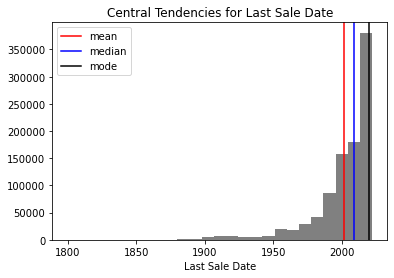

In [196]:
# Plot Central tendency of sale date column
plt.figure()
plt.hist(tc_gdf_non0['Last_Sale_Date'],bins = 25,color = 'grey')
plt.xlabel('Last Sale Date')
plt.axvline(tc_gdf_non0['Last_Sale_Date'].mean(),label = 'mean',color = 'red')
plt.axvline(tc_gdf_non0['Last_Sale_Date'].median(),label = 'median',color = 'blue')
plt.axvline(tc_gdf_non0['Last_Sale_Date'].mode()[0],label = 'mode',color = 'black')
plt.legend()
plt.title('Central Tendencies for Last Sale Date')
plt.show()

The distribution is skewed to the left, with the most frequent sale date in 2020. This makes sense because the sale date figure contains the most recent sale date for each parcel rather than the total number of parcels sold in that year (where each parcel can be sold numerous times). I'll use the median to impute the remaining values.

In [197]:
tc_gdf.loc[tc_gdf['Last_Sale_Date'] == 0, 'Last_Sale_Date'] = median_sale_date

In [198]:
tc_gdf.loc[tc_gdf['Last_Sale_Date'] == 0]

,COUNTY_PIN,County,TAX_NAME,taxed_zip,Use_Class,Last_Sale_Date,HOMESTEAD,YEAR_BUILT,EMV_TOTAL,geometry,Homestead,Corporate


### Use taxed-zip to calculate new field on TAXOWNER_NOTMN (out of state)


In [199]:
tc_gdf['TAXOWN_NOTMN'] = np.where(tc_gdf['taxed_zip'].str.startswith('5'), 0, 1)

In [200]:
tc_gdf.drop(columns='HOMESTEAD', inplace= True)

In [201]:
#check for duplicates
tc_gdf.duplicated().sum()

0

In [ ]:
#Export Final Dataset
tc_gdf.to_file('twincities_parcels.gpkg', driver = 'GPKG')

In [ ]:
tc_gdf.to_csv('twincities_parcels.csv')